Import libraries

In [ ]:
# Reproduction code for Sherwin et al. 2023, "Single-blind validation of space-based point-source detection and quantification of onshore methane emissions"
# Written by Evan D. Sherwin
# 2023

In [69]:
# Import libraries

import pandas as pd
import scipy
import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import scikit-learn
# from scikit-learn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
# import importlib
# import meterUncertainty
import itertools
from scipy import odr
import pathlib
import lxml
import windrose
from datetime import datetime

# importlib.reload(meterUncertainty)

Import data, basic data cleanup and pre-processing

In [185]:
# Import data, basic data cleanup

satelliteResults = pd.read_csv(pathlib.PurePath('01_input_data', 'Satellite_results_consolidated_clean_20230526b.csv'))
kg_per_t = 1000
satelliteResults['Estimate (TPH) num'] = satelliteResults['FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce')/kg_per_t
satelliteResults['ch4_tph_mean'] = satelliteResults['ch4_kgh_mean']/kg_per_t
satelliteResults['ch4_tph_sigma'] = satelliteResults['ch4_kgh_sigma']/kg_per_t
satelliteResults['ch4_pct_sigma'] = satelliteResults['ch4_tph_sigma']/satelliteResults['ch4_tph_mean']
satelliteResults['ch4_pct_95CI_offset'] = satelliteResults['ch4_pct_sigma']*1.96
satelliteResults['Error num'] = (satelliteResults['Estimate (TPH) num'] - satelliteResults['ch4_tph_mean'])*100/satelliteResults['ch4_tph_mean']
satelliteResults['Wind speed est num'] = satelliteResults['WindSpeed'].apply(pd.to_numeric, errors='coerce')
satelliteResults['UnblindingStage'] = satelliteResults['UnblindingStage'].apply(pd.to_numeric, errors='coerce')
satelliteResults['Satellite'] = pd.Categorical(satelliteResults['Satellite'])
satelliteResults['Team'] = pd.Categorical(satelliteResults['Team'])
# satelliteResults['Estimate in situ wind (KGH) num'] = satelliteResults['ISWind FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce')
# satelliteResults['Error in situ wind num'] = satelliteResults['Error in situ wind'].apply(pd.to_numeric, errors='coerce')*100
satelliteResults.head()
# satelliteResults


,Unnamed: 0,Team,Satellite,PerformerExperimentID,FacilityID,EquipmentUnitID,DateOfSurvey,Timestamp (hyperspectral technologies only),StartTime,EndTime,...,average_winddirection,stdev_windspeed,stdev_winddirection,Estimate (TPH) num,ch4_tph_mean,ch4_tph_sigma,ch4_pct_sigma,ch4_pct_95CI_offset,Error num,Wind speed est num
0,0,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-10-18 17:49:00,17:49:00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,1,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-10-26 18:14:00,2022-10-26 18:14:00,NaN,NaN,...,127.334069,0.645598,13.350691,0.000,1.046664,0.029081,0.027784,0.054457,-100.000000,NaN
2,2,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-11-05 18:14:00,18:14:40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 ‚Äì 11/08...,1,1.0,2022-11-08 18:24:00,2022-11-08 18:24:00,NaN,NaN,...,33.992914,0.372414,42.968027,3.215,1.190780,0.018623,0.015639,0.030653,169.991186,3.70
4,4,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 ‚Äì 11/15...,1,1.0,2022-11-15 18:14:00,2022-11-15 18:14:00,NaN,NaN,...,7.717366,0.647588,9.841137,0.903,1.499754,0.022598,0.015068,0.029533,-39.790139,1.68


In [189]:
# Set detection outcomes
min_TN_threshold = 0.010 # t/h

satelliteResults['Detection'] = satelliteResults['QC']
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     np.logical_or((satelliteResults['ch4_tph_mean'] <= min_TN_threshold), pd.isna(satelliteResults['ch4_tph_mean'])), 'Detection'] = 'TN' # Considers a non-detection for any emission less than 0.01 t/h to be a true negative
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     (satelliteResults['ch4_tph_mean'] > min_TN_threshold), 'Detection'] = 'FN'
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     (satelliteResults['Estimate (TPH) num'] > 0) &
                     (satelliteResults['ch4_tph_mean'] == 0), 'Detection'] = 'FP'
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     (satelliteResults['Estimate (TPH) num'] > 0) &
                     (satelliteResults['ch4_tph_mean'] > 0), 'Detection'] = 'TP'

In [142]:
# np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     np.logical_or((satelliteResults['ch4_tph_mean'] <= min_TN_threshold), pd.isna(satelliteResults['ch4_tph_mean'])), 'Detection']

6      TN
7      TN
16     TN
20     TN
21     TN
       ..
384    TN
392    TN
393    TN
414    TN
415    TN
Name: Detection, Length: 67, dtype: object

In [136]:
# Set detection outcomes with lax criteria
min_TN_threshold = 0.010 # t/h

satelliteResults['Detection'] = satelliteResults['QC_lax']
satelliteResults.loc[(satelliteResults['QC_lax']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     np.logical_or((satelliteResults['ch4_tph_mean'] <= min_TN_threshold), pd.isna(satelliteResults['ch4_tph_mean'])), 'Detection'] = 'TN' # Considers a non-detection for any emission less than 10 kg/h to be a true negative
satelliteResults.loc[(satelliteResults['QC_lax']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     (satelliteResults['ch4_tph_mean'] > min_TN_threshold), 'Detection'] = 'FN'
satelliteResults.loc[(satelliteResults['QC_lax']=='OK') &
                     (satelliteResults['Estimate (TPH) num'] > 0) &
                     (satelliteResults['ch4_tph_mean'] == 0), 'Detection'] = 'FP'
satelliteResults.loc[(satelliteResults['QC_lax']=='OK') &
                     (satelliteResults['Estimate (TPH) num'] > 0) &
                     (satelliteResults['ch4_tph_mean'] > 0), 'Detection'] = 'TP'

In [190]:
# # Create SatelliteTeam column
#
satelliteResults['SatelliteTeam'] = satelliteResults['Satellite'].astype('str') + '/' + satelliteResults['Team'].astype('str')
#
# # Reorder satellite and team factor levels
#
satelliteNames = np.unique(satelliteResults['Satellite'])[[3, 1, 2, 4, 0, 5, 6, 7, 8]] # [[0, 2, 3, 1, 4]] # Reorder satellite names to match factor levels
numSatellites = satelliteNames.size
# satelliteResults['SatelliteNum'] = pd.factorize(satelliteResults['Satellite'])[0] + 1
teamNames = np.unique(satelliteResults['Team'])[[2, 3, 4, 1, 0, 5]] # Reorder team names to match factor levels # [[0, 4, 2, 1, 3]] # Reorder team names to match factor levels
numTeams = teamNames.size
# satelliteResults['teamNum'] = pd.factorize(satelliteResults['Team'])[0] + 1
#

In [326]:
# Generate errorbars

yCImult = 1 # 1 #1.96 # Multiplier of standard deviation for 95% confidence interval.
xCImult = yCImult/1.96 # When converting 95% CI in the x-axis to 1-sigma, multiply by this (will be 1 if y-axis uses 95% CI)

satelliteResults['Est high CI offset'] = 0
satelliteResults['Est high CI offset'] = np.subtract(satelliteResults['FacilityEmissionRateUpper'].apply(pd.to_numeric, errors='coerce'),
                                                                                                                          satelliteResults['FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce'))/kg_per_t
satelliteResults['Est low CI offset'] = 0
satelliteResults['Est low CI offset'] = np.subtract(satelliteResults['FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce'),
                                                                                              satelliteResults['FacilityEmissionRateLower'].apply(pd.to_numeric, errors='coerce'))/kg_per_t

satelliteResults['Flux est CI low'] = satelliteResults['Estimate (TPH) num'] - satelliteResults['Est low CI offset']*yCImult
satelliteResults['Flux est CI high'] = satelliteResults['Estimate (TPH) num'] + satelliteResults['Est high CI offset']*yCImult

# Generate x errorbars as offsets from the mean
satelliteResults['xCILower'] = satelliteResults['ch4_tph_sigma']*yCImult
satelliteResults['xCIUpper'] = satelliteResults['ch4_tph_sigma']*yCImult

# Generate x confidence intervals including the mean
satelliteResults['xCILowerFull'] = satelliteResults['ch4_tph_mean'] - satelliteResults['xCILower']
satelliteResults['xCIUpperFull'] = satelliteResults['ch4_tph_mean'] + satelliteResults['xCIUpper']

# Generate wind speed confidence intervals including the mean
satelliteResults['windspeed_CILower'] =  satelliteResults['average_windspeed'] - satelliteResults['stdev_windspeed']*yCImult
satelliteResults['windspeed_CIUpper'] =  satelliteResults['average_windspeed'] + satelliteResults['stdev_windspeed']*yCImult

# Do mean metered values fall within the estimated CI?
satelliteResults['within CI'] = (satelliteResults['ch4_tph_sigma'] >= satelliteResults['Flux est CI low']) | (satelliteResults['ch4_tph_sigma'] <= satelliteResults['Flux est CI high'])

# Convert kg/h to t/h
kg_per_t = 1000
satelliteResults[['ch4_tph_mean', 'xCILower', 'xCIUpper', 'Estimate (TPH) num', 'Est high CI offset', 'Est low CI offset', 'Flux est CI low', 'Flux est CI high']]/kg_per_t


,ch4_tph_mean,xCILower,xCIUpper,Estimate (TPH) num,Est high CI offset,Est low CI offset,Flux est CI low,Flux est CI high
0,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
1,0.001047,2.908095e-05,2.908095e-05,0.000000,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001191,1.862269e-05,1.862269e-05,0.003215,0.000384,0.000384,0.002831,0.003599
4,0.001500,2.259841e-05,2.259841e-05,0.000903,0.000725,0.000725,0.000178,0.001628
...,...,...,...,...,...,...,...,...
411,0.001190,1.856414e-05,1.856414e-05,0.000820,0.000159,0.000272,0.000548,0.000980
412,0.001497,2.203668e-05,2.203668e-05,0.001377,-0.000412,-0.000241,0.001618,0.000966
413,0.001429,2.330319e-05,2.330319e-05,0.000660,-0.000307,-0.000180,0.000840,0.000353
414,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


# First pass at detection figure

Figure 1, Detection results

In [147]:
# Select stage
slct_unblind_stage = 2
satelliteResultsSlctStage = satelliteResults[satelliteResults['UnblindingStage']==slct_unblind_stage]

# Show points with flow  sigma > 10% of mean flow rate
satelliteResultsSlctStage.loc[(satelliteResultsSlctStage['ch4_kgh_sigma']/satelliteResultsSlctStage['ch4_kgh_mean']) > 0.10, ['ch4_kgh_mean', 'ch4_kgh_sigma']]

# selectedTeam = 'LARS' # 'Orbio' 'GHGSat' 'NJU' 'MAXAR' 'LARS' 'Kayrros'
# selectedSatellite = 'WorldView 3'
# selectedSatelliteResults = satelliteResultsSlctStage.loc[(satelliteResultsSlctStage['Satellite'] == selectedSatellite) & (satelliteResultsSlctStage['Team'] == selectedTeam), :]
# selectedSatelliteResults = satelliteResultsSlctStage[satelliteResultsSlctStage['Team'] == selectedTeam]
selectedSatelliteResults = satelliteResultsSlctStage
# selectedSatelliteResults['ch4_kgh_mean'] # ['Estimate (KGH) num']
# np.logical_or((selectedSatelliteResults['Estimate (KGH) num'] == 0), pd.isna(selectedSatelliteResults['Estimate (KGH) num']))

In [148]:
# Table S8
# Detection outcomes by satellite/team combination
# unblindingStage = 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
# selectedSatelliteResults = satelliteResults

# Fraction detected
totalPointsByTeamSat = selectedSatelliteResults.groupby('SatelliteTeam').size()
detectionAccuracy = pd.DataFrame(totalPointsByTeamSat, columns=['Total'])
detectionAccuracy['True positive'] =  selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'TP'].groupby('SatelliteTeam').size()
detectionAccuracy['False negative'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'FN'].groupby('SatelliteTeam').size()
detectionAccuracy['True negative'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'TN'].groupby('SatelliteTeam').size()
detectionAccuracy['False positive'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'FP'].groupby('SatelliteTeam').size()
detectionAccuracy['Operator filtered'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'OE'].groupby('SatelliteTeam').size()
detectionAccuracy['No measurement'] = selectedSatelliteResults.loc[np.logical_or((selectedSatelliteResults['Detection'] == 'NT'), selectedSatelliteResults['Detection'] == 'IM')].groupby('SatelliteTeam').size()
detectionAccuracy['Stanford filtered'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'SE'].groupby('SatelliteTeam').size()
detectionAccuracy['Stanford filtered all'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'SEA'].groupby('SatelliteTeam').size()
detectionAccuracy = detectionAccuracy.fillna(0)
detectionAccuracy['Total included'] = detectionAccuracy['Total'] - detectionAccuracy['Stanford filtered all']
detectionAccuracy['SatelliteTeam'] = detectionAccuracy.index
detectionAccuracy

,Total,True positive,False negative,True negative,False positive,Operator filtered,No measurement,Stanford filtered,Stanford filtered all,Total included,SatelliteTeam
SatelliteTeam,,,,,,,,,,,
EnMap/Kayrros,5,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,EnMap/Kayrros
EnMap/LARS,5,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,5.0,EnMap/LARS
EnMap/MAXAR,5,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,5.0,EnMap/MAXAR
EnMap/NJU,5,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,5.0,EnMap/NJU
GF5/Kayrros,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,GF5/Kayrros
GF5/LARS,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,GF5/LARS
GF5/NJU,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,GF5/NJU
GHGSat CX/GHGSat,12,1.0,0.0,1.0,0.0,3.0,5.0,0.0,2.0,10.0,GHGSat CX/GHGSat
HJ2B/LARS,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,HJ2B/LARS


In [234]:
# Total counts across all satellite-team combinations
total_counts_by_detection_category = detectionAccuracy.sum(axis=0)
total_counts_by_detection_category

Total                                                                  208
True positive                                                         46.0
False negative                                                        41.0
True negative                                                         34.0
False positive                                                         0.0
Operator filtered                                                      5.0
No measurement                                                        13.0
Stanford filtered                                                      9.0
Stanford filtered all                                                 60.0
Total included                                                       148.0
SatelliteTeam            EnMap/KayrrosEnMap/LARSEnMap/MAXAREnMap/NJUGF5...
dtype: object

In [237]:
# All Stanford-filtered estimates
tot_filtered_by_Stanford = total_counts_by_detection_category['Stanford filtered'] + total_counts_by_detection_category['Stanford filtered all']
tot_filtered_by_Stanford

69.0

In [381]:
# Total estimates not filtered by Stanford
tot_not_filtered = total_counts_by_detection_category['Total'] - tot_filtered_by_Stanford - total_counts_by_detection_category['Operator filtered']
tot_not_filtered

134.0

In [382]:
# Totals as a fraction of estimates not filtered by Stanford
detection_frac_not_filtered = total_counts_by_detection_category.apply(pd.to_numeric, errors='coerce')/tot_not_filtered
detection_frac_not_filtered

Total                    1.552239
True positive            0.343284
False negative           0.305970
True negative            0.253731
False positive           0.000000
Operator filtered        0.037313
No measurement           0.097015
Stanford filtered        0.067164
Stanford filtered all    0.447761
Total included           1.104478
SatelliteTeam                 NaN
dtype: float64

In [383]:
# True positive/negative
total_counts_by_detection_category['True positive'] + total_counts_by_detection_category['True negative'], detection_frac_not_filtered_by_Stanford['True positive'] + detection_frac_not_filtered_by_Stanford['True negative']

(80.0, 0.5755395683453237)

In [149]:
# Detection outcomes across all satellites

# Total estimates reported by all teams across all satellites
detectionAccuracyAllTeams = np.sum(detectionAccuracy.drop(columns='SatelliteTeam'))
detectionAccuracyAllTeams, detectionAccuracyAllTeams/detectionAccuracyAllTeams[0]

# Convert above counts in to a fraction of total measurements for each team and satellite (excluding measurements excluded across all teams)

detectionFraction = 100*pd.DataFrame(detectionAccuracy.drop(columns=['Total', 'SatelliteTeam']).div(detectionAccuracy['Total'] - detectionAccuracy['Stanford filtered all'], axis='rows'))
detectionFraction[np.isnan(detectionFraction)] = 0
detectionFraction

,True positive,False negative,True negative,False positive,Operator filtered,No measurement,Stanford filtered,Stanford filtered all,Total included
SatelliteTeam,,,,,,,,,
EnMap/Kayrros,20.000000,0.000000,80.000000,0.0,0.000000,0.000000,0.0,0.000000,100.0
EnMap/LARS,20.000000,0.000000,20.000000,0.0,0.000000,0.000000,60.0,0.000000,100.0
EnMap/MAXAR,20.000000,0.000000,20.000000,0.0,0.000000,0.000000,60.0,0.000000,100.0
EnMap/NJU,0.000000,20.000000,20.000000,0.0,0.000000,0.000000,60.0,0.000000,100.0
GF5/Kayrros,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,100.000000,100.0
GF5/LARS,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,100.000000,100.0
GF5/NJU,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,100.000000,100.0
GHGSat CX/GHGSat,10.000000,0.000000,10.000000,0.0,30.000000,50.000000,0.0,20.000000,100.0
HJ2B/LARS,0.000000,0.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,100.0


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


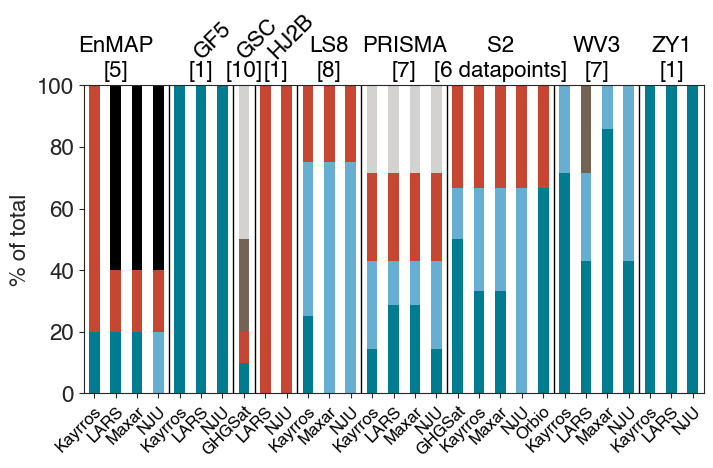

In [150]:
# Figure 1, detection plot
# Colors: https://identity.stanford.edu/design-elements/color/accent-colors/
# ['#007C92', '#67AFD2', '#C74632', '#F4795B', '#766253', '#D4D1D1']

fig, ax = plt.subplots()
#plt.font_manager._rebuild()
labelsize = 16
smalltextsize = 12
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Helvetica'})
# rc('font',**{'family':'serif','serif':['Hel vetica']})
bar1 = ax.bar(detectionFraction.index, detectionFraction['True positive'], width=0.5, ec='None', color='#007C92')
bar2 = ax.bar(detectionFraction.index, detectionFraction['False negative'], bottom=detectionFraction['True positive'], ec='None', width=0.5, color='#67AFD2')
bar3 = ax.bar(detectionFraction.index, detectionFraction['True negative'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'], ec='None', width=0.5, color='#C74632')
bar4 = ax.bar(detectionFraction.index, detectionFraction['False positive'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'], ec='None', width=0.5, color='#F4795B')
bar5 = ax.bar(detectionFraction.index, detectionFraction['Operator filtered'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'], ec='None', width=0.5, color='#766253')
bar6 = ax.bar(detectionFraction.index, detectionFraction['No measurement'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'] + detectionFraction['Operator filtered'], ec='None', width=0.5, color='#D4D1D1')
bar7 = ax.bar(detectionFraction.index, detectionFraction['Stanford filtered'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'] + detectionFraction['Operator filtered'] + detectionFraction['No measurement'], ec='None', width=0.5, color='black')

# for jj in np.arange(0, detectionAccuracy.iloc[:,0].size):
#     ax.text(jj-0.14, 100.6, detectionAccuracy.iloc[jj,0], fontsize=16, color='black', rotation='horizontal') # kgh
plt.ylabel('% of total', size=labelsize)
# plt.xlabel('Team', size=16)
plt.xticks(np.arange(0, detectionAccuracy.iloc[:,0].size, 1), fontsize=smalltextsize, rotation=90)
ax.set_xticklabels(['Kayrros','LARS','Maxar','NJU','Kayrros','LARS','NJU','GHGSat', 'LARS', 'NJU', 'Kayrros', 'Maxar', 'NJU', 'Kayrros', 'LARS', 'Maxar', 'NJU', 'GHGSat', 'Kayrros', 'Maxar', 'NJU', 'Orbio', 'Kayrros', 'LARS', 'Maxar', 'NJU', 'Kayrros', 'LARS', 'NJU'], rotation=45, rotation_mode='anchor', ha='right', size=smalltextsize, color='black')
plt.text(1, 103, 'EnMAP\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('EnMap'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -63
plt.text(4.5, 109, 'GF5', fontsize=labelsize, color='black', rotation=45, ha='left') # -70
plt.text(5, 103, '['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('GF5'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -70
plt.text(6.5, 109, 'GSC', fontsize=labelsize, color='black', rotation=45, ha='left') # -64
plt.text(7, 103, '['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('GHGSat'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -64
plt.text(8, 109, 'HJ2B', fontsize=labelsize, color='black', rotation=45, ha='left') # -68
plt.text(8.5, 103, '['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('HJ2B'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -68
plt.text(11, 103, 'LS8\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('LandSat'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.text(14.5, 103, 'PRISMA\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('PRISMA'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.text(19, 103, 'S2\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('Sentinel-2'), 'Total included'][0]))+' datapoints]', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.text(23.5, 103, 'WV3\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('WorldView 3'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.text(27, 103, 'ZY1\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('ZY'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.axvline(3.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(6.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(7.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(9.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(12.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(16.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(21.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(25.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.yticks(np.arange(0, 101, 20), fontsize=labelsize)
plt.ylim(0,100) # 107
plt.xlim(-0.5,28.5)
# plt.xlim(-0.5,11.5)


# plt.text(11+0.6, 100.4, '# Total', fontsize=18, color='black', rotation='horizontal') # kgh
# plt.text(-3, -20, 'Team', fontsize=20, color='black', rotation=0) # -55
# ax.legend(labels=detectionFraction.columns) # , handles=[bar1, bar2, bar3, bar4, bar5, bar6]
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
# plt.rcParams['text.usetex'] = True # http://phyletica.org/matplotlib-fonts/
# plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = 8,4 # 8,4
# plt.savefig(pathlib.PurePath('02_figures', 'Detections ' + selectedTeam + ' 20230418b.png'), format='png', bbox_inches="tight")
# plt.savefig(pathlib.PurePath('02_figures', 'Detections lax' + selectedTeam + ' 20230417.png'), format='png', bbox_inches="tight")
plt.savefig(pathlib.PurePath('02_figures', 'Detections all teams 20230525.pdf'), format='pdf', bbox_inches="tight")
# plt.savefig(pathlib.PurePath('02_figures', 'Detections all teams laxQX 20230509.png'), format='png', bbox_inches="tight")
# plt.show()

In [ ]:
detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('EnMap'), 'Total included'][0]

Metered emission rates for key measurements

In [221]:
# Emissions with a metered 5-minute flow variability with a 95% confidence interval >20% of mean flow
flow_rate_CI_fields = ['SatelliteTeam', 'DateOfSurvey', 'ch4_tph_mean', 'xCILowerFull', 'xCIUpperFull', 'average_windspeed', 'windspeed_CILower', 'windspeed_CIUpper', 'average_winddirection', 'stdev_windspeed', 'stdev_winddirection', 'Estimate (TPH) num', 'Flux est CI low', 'Flux est CI high', 'ch4_pct_95CI_offset', 'Error num']

satelliteResults.loc[(satelliteResults['ch4_pct_95CI_offset'] > 0.20) &
                     (satelliteResults['UnblindingStage'] == 1),
                     flow_rate_CI_fields]

,SatelliteTeam,DateOfSurvey,ch4_tph_mean,xCILowerFull,xCIUpperFull,average_windspeed,windspeed_CILower,windspeed_CIUpper,average_winddirection,stdev_windspeed,stdev_winddirection,Estimate (TPH) num,Flux est CI low,Flux est CI high,ch4_pct_95CI_offset,Error num
26,GF5/Kayrros,2022-11-15 00:00:00,1.260205,0.260147,2.260263,2.127407,0.281656,3.973158,27.75992,0.94171,18.128746,1.19500,-0.039800,2.429800,0.793568,-5.174159
68,ZY1/Kayrros,2022-10-20 00:00:00,0.944126,0.367566,1.520686,NaN,NaN,NaN,NaN,NaN,NaN,2.18300,0.217120,4.148880,0.610681,131.219147
77,GF5/LARS,2022-11-15 00:00:00,1.260205,0.260147,2.260263,2.127407,0.281656,3.973158,27.75992,0.94171,18.128746,1.25529,0.630442,1.880158,0.793568,-0.390017
92,ZY1/LARS,2022-10-20 00:00:00,0.944126,0.367566,1.520686,NaN,NaN,NaN,NaN,NaN,NaN,1.34381,0.491720,2.195900,0.610681,42.333762
154,GF5/NJU,2022-11-15 00:00:00,1.260205,0.260147,2.260263,2.127407,0.281656,3.973158,27.75992,0.94171,18.128746,1.24000,0.267840,2.210200,0.793568,-1.603311
197,ZY1/NJU,2022-10-20 00:00:00,0.944126,0.367566,1.520686,NaN,NaN,NaN,NaN,NaN,NaN,0.79900,0.238440,1.359560,0.610681,-15.371462


In [198]:
# Emissions with a metered 5-minute flow variability with a 95% confidence interval >10% of mean flow
satelliteResults.loc[(satelliteResults['ch4_pct_95CI_offset'] > 0.10) &
                     (satelliteResults['UnblindingStage'] == 1), flow_rate_CI_fields]

,SatelliteTeam,DateOfSurvey,ch4_tph_mean,xCILowerFull,xCIUpperFull,average_windspeed,windspeed_CILower,windspeed_CIUpper,average_winddirection,stdev_windspeed,stdev_winddirection,Estimate (TPH) num,Flux est CI low,Flux est CI high,ch4_pct_95CI_offset
8,GHGSat CX/GHGSat,2022-10-11 20:51:00,0.031557,0.026135,0.036980,3.258831,0.815717,5.701944,104.169405,1.246487,14.811450,NaN,NaN,NaN,0.171825
26,GF5/Kayrros,2022-11-15 00:00:00,1.260205,0.260147,2.260263,2.127407,0.281656,3.973158,27.759920,0.941710,18.128746,1.19500,-0.039800,2.429800,0.793568
48,PRISMA/Kayrros,2022-11-30 00:00:00,0.979529,0.877944,1.081114,4.111929,2.967785,5.256074,131.676061,0.583747,10.017418,0.00000,NaN,NaN,0.103708
58,WorldView 3/Kayrros,2022-10-17 00:00:00,0.041956,0.034341,0.049571,1.642526,0.550507,2.734546,359.631474,0.557153,20.484271,0.00000,NaN,NaN,0.181501
68,ZY1/Kayrros,2022-10-20 00:00:00,0.944126,0.367566,1.520686,NaN,NaN,NaN,NaN,NaN,NaN,2.18300,0.217120,4.148880,0.610681
77,GF5/LARS,2022-11-15 00:00:00,1.260205,0.260147,2.260263,2.127407,0.281656,3.973158,27.759920,0.941710,18.128746,1.25529,0.630442,1.880158,0.793568
88,PRISMA/LARS,2022-11-30 00:00:00,0.979529,0.877944,1.081114,4.111929,2.967785,5.256074,131.676061,0.583747,10.017418,0.45219,0.172792,0.731588,0.103708
92,ZY1/LARS,2022-10-20 00:00:00,0.944126,0.367566,1.520686,NaN,NaN,NaN,NaN,NaN,NaN,1.34381,0.491720,2.195900,0.610681
129,PRISMA/MAXAR,2022-11-30 00:00:00,0.979529,0.877944,1.081114,4.111929,2.967785,5.256074,131.676061,0.583747,10.017418,NaN,NaN,NaN,0.103708
139,WorldView 3/MAXAR,2022-10-17 00:00:00,0.041956,0.034341,0.049571,1.642526,0.550507,2.734546,359.631474,0.557153,20.484271,0.00000,0.000000,0.325914,0.181501


In [225]:
# Metered flow rates for emissions metered in Figure 3 and selected others
# flow_rate_CI_fields = ['SatelliteTeam', 'DateOfSurvey', 'ch4_tph_mean', 'xCILowerFull', 'xCIUpperFull', 'average_windspeed', 'windspeed_CILower', 'windspeed_CIUpper', 'average_winddirection', 'stdev_windspeed', 'stdev_winddirection', 'Estimate (TPH) num', 'Flux est CI low', 'Flux est CI high']
satelliteResults.loc[[73, 77, 91, 1, 3, 14, 60, 64, 48, 44, 22, 68, 35, 36, 201], flow_rate_CI_fields]

,SatelliteTeam,DateOfSurvey,ch4_tph_mean,xCILowerFull,xCIUpperFull,average_windspeed,windspeed_CILower,windspeed_CIUpper,average_winddirection,stdev_windspeed,stdev_winddirection,Estimate (TPH) num,Flux est CI low,Flux est CI high,ch4_pct_95CI_offset,Error num
73,EnMap/LARS,2022-11-16 00:00:00,1.095424,1.064747,1.126101,5.447682,3.726956,7.168409,341.417192,0.877922,15.757011,1.533220,0.356181,2.710259,0.028005,39.965856
77,GF5/LARS,2022-11-15 00:00:00,1.260205,0.260147,2.260263,2.127407,0.281656,3.973158,27.759920,0.941710,18.128746,1.255290,0.630442,1.880158,0.793568,-0.390017
91,ZY1/LARS,2022-10-26 00:00:00,1.032692,0.977818,1.087566,2.344396,0.958229,3.730563,140.652837,0.707228,10.712700,1.633460,0.832800,2.434120,0.053137,58.174893
1,Sentinel-2/GHGSat,2022-10-26 18:14:00,1.046664,0.989665,1.103662,2.393014,1.127642,3.658386,127.334069,0.645598,13.350691,0.000000,NaN,NaN,0.054457,-100.000000
3,Sentinel-2/GHGSat,2022-11-08 18:24:00,1.190780,1.154279,1.227280,0.496504,-0.233427,1.226435,33.992914,0.372414,42.968027,3.215000,2.462360,3.967640,0.030653,169.991186
14,GHGSat CX/GHGSat,2022-11-08 20:51:00,0.401432,0.399018,0.403847,1.639353,0.820863,2.457843,79.463424,0.417597,29.868490,0.496000,0.155803,0.836197,0.006014,23.557542
60,WorldView 3/Kayrros,2022-10-29 00:00:00,0.033180,0.032762,0.033599,2.426815,1.115121,3.738510,35.815827,0.669232,14.926105,0.000000,NaN,NaN,0.012606,-100.000000
64,WorldView 3/Kayrros,2022-11-22 00:00:00,0.432792,0.430052,0.435533,1.416195,0.877254,1.955137,294.200238,0.274970,10.360405,0.460000,-0.149560,1.069560,0.006333,6.286509
48,PRISMA/Kayrros,2022-11-30 00:00:00,0.979529,0.877944,1.081114,4.111929,2.967785,5.256074,131.676061,0.583747,10.017418,0.000000,NaN,NaN,0.103708,-100.000000
44,PRISMA/Kayrros,2022-11-07 00:00:00,0.413583,0.410265,0.416901,0.700931,-0.215712,1.617573,144.026426,0.467675,44.908502,0.627000,-0.125640,1.379640,0.008022,51.601906


In [224]:
# Small Sentinel-2 % error
satelliteResults.loc[[3, 135, 203, 201], ['SatelliteTeam', 'DateOfSurvey', 'Error num']]

,SatelliteTeam,DateOfSurvey,Error num
3,Sentinel-2/GHGSat,2022-11-08 18:24:00,169.991186
135,Sentinel-2/MAXAR,2022-11-18 00:00:00,49.459817
203,Sentinel-2/Orbio,2022-11-08 00:00:00,-8.780418
201,Sentinel-2/Orbio,2022-10-26 00:00:00,-46.937690


In [220]:
# Comparison of smallest Sentinel-2 detections with smallest S2 detection in Sherwin et al. 2023
min_S2_prior_text = 1.4 # t/h
1 - satelliteResults.loc[[3, 201], 'ch4_tph_mean']/min_S2_prior_text

3      0.149443
201    0.252400
Name: ch4_tph_mean, dtype: float64

Parity plots

In [349]:
# Set color palette
# colors =  np.array(['#7F7776', '#D1660F', '#007C92', '#734675', '#C74632', 'black', 'pink', 'saddlebrown', 'green'])# np.array(['#C74632', '#D1660F', '#007C92', '#7F7776', '#734675'])[[3, 1, 2, 4, 0]]
# colorsForErrorbars = np.array(['#C74632', '#7F7776', '#D1660F', '#007C92', '#734675', 'black', 'pink', 'saddlebrown', 'green']) # np.array(['#7F7776', '#D1660F', '#007C92', '#734675', '#C74632'])
# Uses Stanford colors: https://identity.stanford.edu/design-elements/color/accent-colors/
colors = np.array(['#016895', '#4298B5', '#734675', '#FEC51D', '#B6B1A9', '#279989', '#E98300', '#E04F39', 'black']) # #014240
markers = np.array(['o', 'X', 's', 'P', 'd', 'v'])
# Set your custom color palette
sns.color_palette('Set2')

# For identifying non-detects with floating point precision
non_detect_pct_err_bound = -100 + 0.00000001
# StanfordPalette = sns.set_palette(sns.color_palette(colors))
# StanfordPalette

Define function to generate parity charts

In [352]:
def parityPlot(filename, foldername = '02_figures', satellitedata=satelliteResults, satellite='All', team='All', stage=1, axisbound=6, linfitTextX = 6.750, linfitTextY = 4.200, linfitspacing = 0, qc='default', includeReg='Yes'):
    # fig = plt.gcf()
    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]}, figsize=(5.9, 4.9)) # (5, 4.9)
    unblindingStage = stage # 1 # 2
    selectedSatellite = satellite
    selectedTeam = team
    axistick_fontsize = 9.7 # 14
    axislabel_fontsize = 14 # 14
    legend_fontsize = axistick_fontsize # 9.5
    marker_size = 40

    # Filter for unblinding stage
    # Exclude zeros
    satellitedata = satellitedata[(satellitedata['UnblindingStage']==stage)]

    # Apply QC criteria
    if qc == 'default':
        satellitedata = satellitedata[satellitedata['QC']=='OK']
    elif qc == 'lax':
        satellitedata = satellitedata[satellitedata['QC_lax']=='OK']

    if satellite == 'All':
        if team == 'All':
            selectedSatelliteResults = satellitedata
            # selectedSatelliteResults = satellitedata[satellitedata['UnblindingStage']==unblindingStage]
    if (satellite != 'All') & (team != 'All'):
        selectedSatelliteResults = satellitedata[(satellitedata['Satellite']==selectedSatellite) & (satellitedata['Team']==selectedTeam)]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif satellite != 'All':
        selectedSatelliteResults = satellitedata[satellitedata['Satellite']==selectedSatellite]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif team != 'All':
        selectedSatelliteResults = satellitedata[satellitedata['Team']==selectedTeam]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]

    # Select out zeros
    selectedSatelliteResultsZeros = selectedSatelliteResults[selectedSatelliteResults['Estimate (TPH) num'] == 0]

    # Remove zeros from main data frame
    selectedSatelliteResults = selectedSatelliteResults[selectedSatelliteResults['Estimate (TPH) num'] > 0]
    # selectedSatellite = 'WV3' # 'PRISMA' # 'GHGSat C2' # 'Landsat 8' 'Sentinel-2' 'WV3'
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    # selectedTeam =  'Kayrros'# 'SRON' # 'Harvard' # 'LARS'# 'GHGSat'# 'Kayrros'
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]
    selectedSatelliteNames = selectedSatelliteResults['Satellite'].cat.categories# np.unique(selectedSatelliteResults['Satellite'])
    selectedSatellitePos = np.in1d(satelliteNames, selectedSatelliteNames) #np.where(satelliteNames == selectedSatellite)[0][0] - 1
    selectedSatelliteNames = selectedSatelliteNames.tolist()
    selectedTeamNames = selectedSatelliteResults['Team'].cat.categories# np.unique(selectedSatelliteResults['Team'])
    teamPos = np.in1d(teamNames, selectedTeamNames)
    # colors =  np.array(['#C74632', '#D1660F', '#007C92', '#7F7776', '#734675', 'black', 'pink', 'purple', 'green'])
    # slctColors = colors[selectedSatellitePos]

    # slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]
    #
    # Uses Stanford colors: https://identity.stanford.edu/design-elements/color/accent-colors/
    colorsForErrorbars = np.array(['#016895', '#4298B5', '#734675', '#FEC51D', '#B6B1A9', '#279989', '#E98300', '#E04F39', 'black']) # #014240
    # np.array(['#007C92', '#7F7776', '#D1660F', '#734675', '#C74632', 'black', 'pink', 'saddlebrown', 'green'])
    if (satellite=='All') & (team=='All'):
        slctColorsForErrorbars =  colorsForErrorbars # colors[[4, 2, 0, 1, 3, 5, 6, 7, 8]]
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbars))# StanfordPalette = sns.set_palette(sns.color_palette(slctColors))
    elif (team!='All') & (satellite!='All'):
        slctColorsForErrorbarsInit = colorsForErrorbars[0]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit# [[1, 3, 0, 2, 4]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette([slctColorsForErrorbarsInit]))
    elif (team=='Kayrros'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4, 5, 6]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='LARS'): # elif (team=='LARS') & (stage==1):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 4, 3]] # slctColorsForErrorbarsInit[[0, 1, 2, 4, 3]]
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    # elif (team=='LARS') & (stage==2):
    #     slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    #     slctColorsForErrorbars =  slctColorsForErrorbarsInit[[0, 1, 2, 3]] # slctColorsForErrorbarsInit[[0, 1, 2, 4, 3]]
    #     StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='MAXAR'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4]]# [[1, 3, 0, 2, 4]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='NJU'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4, 5, 6, 7]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='Orbio'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='GHGSat'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[1, 0]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    else:
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    # if (team == 'SRON') | (team == 'Harvard') | (satellite != 'All'):
    #     slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])
    # else: slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]

    # slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]

    # For main plots, LARS, and Kayrros
     # np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])  # colorsForErrorbars[selectedSatellitePos]
    # For individual satellites and teams
    # slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])

    subsetMarkers = np.array(['o', 'X', 's', 'P', 'd', 'v'])# np.array(['X', 's', 'P', 'd', 'o', 'v'])
    if (satellite=='All') & (team=='All'):
        slctMarkers = markers[teamPos].tolist()
    else:
        slctMarkers = subsetMarkers[teamPos].tolist()

    # Construct the main scatter plot
    mainScatterPlot = sns.scatterplot(data=selectedSatelliteResults, x='ch4_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', markers=slctMarkers, linewidth=0, s=marker_size, ax=axes[0]) # s=80, legend=False) # 'logged KGH', palette='tab10'
    axes[0].tick_params(labelbottom=False, labelsize=axislabel_fontsize)
    axes[0].set_xlabel("")

    # mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_ch4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    # mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_ch4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    # In situ wind
    # mainScatterPlot = sns.relplot(data=satelliteResults[satelliteResults['UnblindingStage']==2], x='cr_kgh_ch4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    lims = [0, 8.000] # [-0.100, 8.000]
    lims_df = pd.DataFrame(data={'x':lims, 'y':lims})
    sns.lineplot(data=lims_df, x='x', y='y', color='black', ax=axes[0])
    # sns.move_legend(mainScatterPlot, 'lower right', bbox_to_anchor=(0.99, 0.14)) # sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))
    # mainScatterPlot._legend.set_frame_on(True)

    # plt.errorbar(x=satelliteResults['Estimate (kgh) mean'], y=satelliteResults['Estimate (KGH) num'], xerr=meteredErrorbarsFlat, yerr=satelliteResults['Estimate (KGH) num']*0.1, fmt='.')
    # satelliteResults['Estimate (kgh) P97_5'] - satelliteResults['Estimate (kgh) mean']
    # sns.set_style("white")
    # plt.axhline(1000, ls='--', linewidth=3, color='red')
    # plt.plot([0,0], [8000,8000])
    # mainScatterPlot.ax_joint.plot([0,0], [8000,8000], '-', linewidth = 2)

    # Set axis bounds for top panel
    axes[0].set_xlim(0,axisbound) #10000 -0.100
    axes[0].set_ylim(0,axisbound) #10000 -0.100

    # plt.xlim(-0.100,axisbound) #10000
    # plt.ylim(-0.100,axisbound) #10000
    # # mainScatterPlot._legend.set_title("Satellite")
    # mainScatterPlot._legend.set_title(None)
    # mainScatterPlot._legend.remove()

    # Comment out to remove legend
    # plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0, fontsize=12)#, title_fontsize= 'large')

    # plt.legend(fontsize= 60)
    # mainScatterPlot._legend.draw_frame(True)
    # plt.xlabel('Metered emissions [t(CH$_4$)/h]', fontsize=18)
    plt.xlabel("", fontsize=axislabel_fontsize)
    plt.ylabel('Estimated emissions [t(CH$_4$)/h]', fontsize=axislabel_fontsize)
    plt.xticks(fontsize=axislabel_fontsize)
    # plt.xticks([])
    plt.yticks(fontsize=axislabel_fontsize)

    colorCounter = 0
    # shapes = itertools.cycle(['o', 'x', 's', '+', 'd'])
    for satelliteName in selectedSatelliteNames:
        selectedData = selectedSatelliteResults.loc[(selectedSatelliteResults['Satellite'] == satelliteName)]
        if len(selectedData) == 0:
            colorCounter = colorCounter + 1 # If there are no data points for the selected satellite, just advance the color counter
        else:
            slctMeteredErrorbars = selectedData[['xCILower', 'xCIUpper']] #.sub(selectedData['cr_kgh_ch4_mean300'], axis='index')
            slctMeteredErrorbarsFlat = np.concatenate(np.array(slctMeteredErrorbars)).reshape(len(slctMeteredErrorbars), 2).transpose()
            # selectedErrors = satelliteResults.loc[(satelliteResults['Satellite'] == satellite)]
            slctColor = slctColorsForErrorbars[colorCounter]
            # if (team == 'Orbio') | (satellite != 'All'):
            #     slctColor = slctColorsForErrorbars[0]
            # else:
            #     slctColor = slctColorsForErrorbars[colorCounter] #
                # slctColor = slctColorsForErrorbars[[2, 3, 1, 8, 4, 5, 0, 6, 7]][colorCounter] #

            # print(satellite)
            # print(slctColor)

            # plt.errorbar(selectedData['Estimate (kgh) mean'],
            #             selectedData['Estimate (KGH) num'], xerr=slctMeteredErrorbarsFlat, yerr=selectedData['Estimate (KGH) num']*0.1, fmt='.', color=slctColor)
            axes[0].errorbar(selectedData['ch4_tph_mean'], selectedData['Estimate (TPH) num'],
                         xerr=np.array([selectedData['xCILower']*xCImult, #*xCImult
                                        selectedData['xCIUpper']*xCImult]), #*xCImult
                         # xerr=np.array([np.abs(selectedData['cr_kgh_ch4_lower300'] -
                         #                       selectedData['cr_kgh_ch4_mean300']), #*xCImult
                         #                np.abs(selectedData['cr_kgh_ch4_upper300'] -
                         #                       selectedData['cr_kgh_ch4_mean300'])]), #*xCImult
                         yerr=np.array([np.abs(selectedData['Flux est CI low'] -
                                               selectedData['Estimate (TPH) num']),
                                        np.abs(selectedData['Flux est CI high'] -
                                               selectedData['Estimate (TPH) num'])]), fmt='.', color=slctColor, alpha=0.5)
                                               # selectedData['Estimate (TPH) num'])]), fmt='.', color=slctColor, alpha=0.5)
            colorCounter = colorCounter + 1

    # plt.rcParams["figure.figsize"] = (6,5)
    #sns.set(rc={"figure.figsize":(10, 5)})
    sns.set_style("ticks") # "whitegrid" "white"

    # Linear regression for satellite data, forced zero intercept
    if (includeReg=='Yes'):
        regData = selectedSatelliteResults.loc[(selectedSatelliteResults['Estimate (TPH) num'] > 0), ['ch4_tph_mean', 'Estimate (TPH) num']]
        regData.columns = ['x', 'y']
        model = smf.ols(formula="y ~ x + 0", data=regData)
        # model = smf.ols(formula="y ~ x", data=regData)
        result = model.fit()
        # result.summary()
        results_as_html_main = result.summary().tables[1].as_html()
        results_as_html_r2 = result.summary().tables[0].as_html()
        # results_as_html
        results_main = pd.read_html(results_as_html_main, header=0, index_col=0)[0]
        results_r2_and_more = pd.read_html(results_as_html_r2, header=0, index_col=0)[0]
        results_r2 = str(np.abs(float(results_r2_and_more.columns[2]))) # Prevent the possibility of a -0 R squared by doing absolute value
        results_coeff = results_main['coef'][0]

        x_domain = np.array([lims[0], lims[1]]) #.reshape(-1,1)
        y_pred = x_domain*results_coeff
        xy_df = pd.DataFrame(data={'x':x_domain, 'y':y_pred})

        sns.lineplot(data=xy_df, x='x', y='y', color='gray', dashes=[2, 2], ax=axes[0]) # , style='-'
        # axes[0].plot(x_domain, y_pred, '-', color='gray', linewidth=3)
        axes[0].text(linfitTextX+0.02, linfitTextY, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=axislabel_fontsize, color='gray', rotation=0, ha='left') # -63
        axes[0].text(linfitTextX, linfitTextY - 0.25 - linfitspacing, 'R$^2$='+results_r2, fontsize=axislabel_fontsize, color='gray', rotation=0, ha='left') # -63
    # For in situ wind case
    # plt.text(6750, 5000, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=18, color='gray', rotation=0, ha='right') # -63
    # plt.text(6600, 4500, 'R$^2$='+results_r2, fontsize=18, color='gray', rotation=0, ha='right') # -63

    # plt.tight_layout()

    # Save strip of zeros

    zerosPlot = sns.scatterplot(data=selectedSatelliteResultsZeros, x='ch4_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', markers=slctMarkers, s=marker_size, alpha=0.4, legend=False, ax=axes[1]) # 'logged KGH', palette='tab10' height=0.3, aspect=17
    detect_plot_strip_width = 0.01
    axes[1].set_xlim(0,axisbound)
    # plt.gcf().patch.set_edgecolor('black')
    axes[1].set_ylim(-detect_plot_strip_width, detect_plot_strip_width)
    # plt.xlabel('Metered emissions [t(CH$_4$)/h]', fontsize=14)
    plt.xticks(fontsize=axistick_fontsize)
    # zerosPlot.set(ylabel=None)

    # Set axis ticks
    sns.set_style("ticks")
    ticklabels = np.arange(0, axisbound + 0.5, 0.5)
    axes[0].set_xticks(ticklabels)
    axes[0].set_yticks(ticklabels)
    axes[0].set_xticklabels(ticklabels, fontsize=axistick_fontsize)
    axes[0].set_yticklabels(ticklabels, fontsize=axistick_fontsize)
    axes[1].set_yticklabels(['', 0.0, ''], fontsize=axistick_fontsize)

    # Set axis labels
    axes[1].set_xlabel('Metered emissions [t(CH$_4$)/h]', size=axislabel_fontsize)
    axes[0].set_ylabel('Estimated emissions\n[t(CH$_4$)/h]', size=axislabel_fontsize)
    axes[1].set_ylabel('Non-\ndetects', size=16)

    # leg = axes[0].legend()
    # leg.get_frame().set_edgecolor('black')
    axes[0].legend(loc = 'upper left', bbox_to_anchor=(1.02, 1.03), fontsize=legend_fontsize, edgecolor='black')# , mode='expand', borderaxespad=0.) # (1.02, 1.03)

    plt.tight_layout()
    # plt.savefig(pathlib.PurePath(foldername, 'Zeros' + filename), format='png')
    plt.savefig(pathlib.PurePath(foldername, filename), format='pdf')

    # plt.show()


/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator


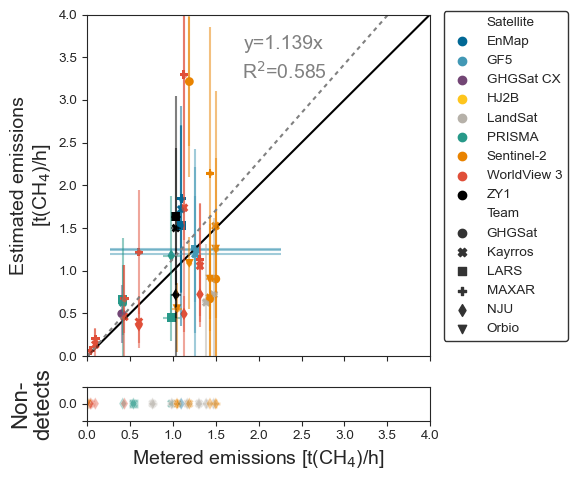

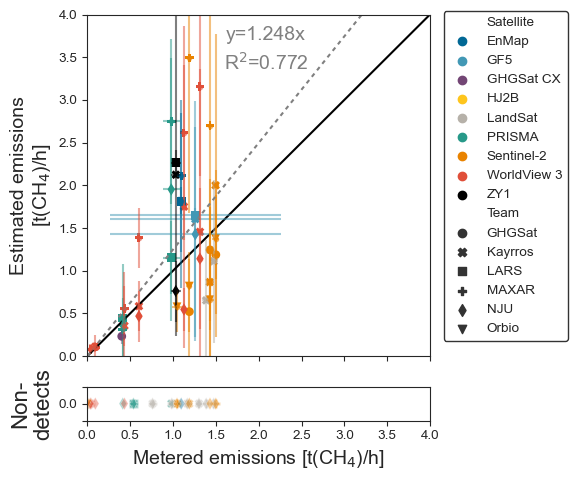

In [160]:
# Generate parity plots

# Remove LARS WV3 quantification, which was submitted off-cycle
satelliteResultsNoLARSWV3 = satelliteResults[satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS']

# Stage 1
# parityPlot(filename='Satellite parity stage 1 20230509.png', axisbound=8, linfitTextX=3.6, linfitTextY=7.2, linfitspacing=0.5, satellitedata=satelliteResults)
parityPlot(filename='Satellite parity stage 1 zoom 20230526b.pdf', axisbound=4, linfitTextX=1.8, linfitTextY=3.6, linfitspacing=0.1, satellitedata=satelliteResultsNoLARSWV3)
#
# # Stage 2
# parityPlot(filename='Satellite parity stage 2 20230509.png', axisbound=8, linfitTextX=3.2, linfitTextY=7.4, linfitspacing=0.5, satellitedata=satelliteResults, stage=2)
parityPlot(filename='Satellite parity stage 2 zoom 20230526b.pdf', axisbound=4, linfitTextX=1.6, linfitTextY=3.7, linfitspacing=0.1, satellitedata=satelliteResultsNoLARSWV3, stage=2)

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: V

<Figure size 600x500 with 0 Axes>

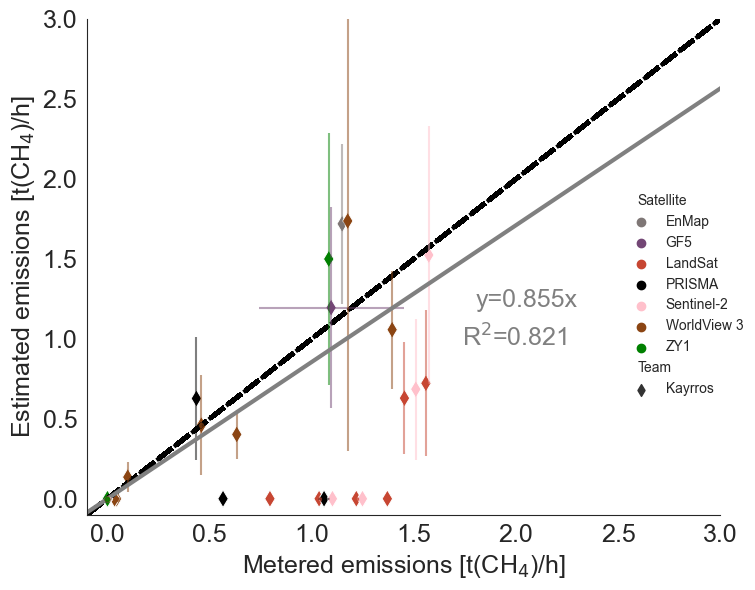

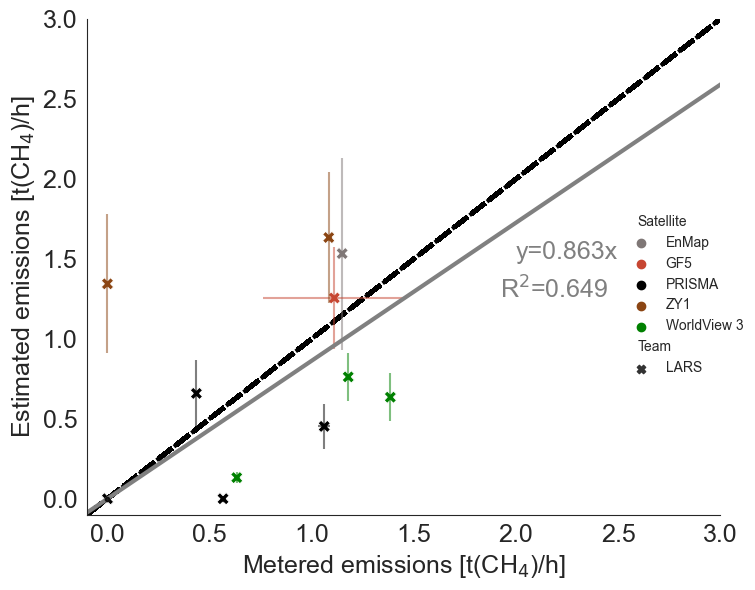

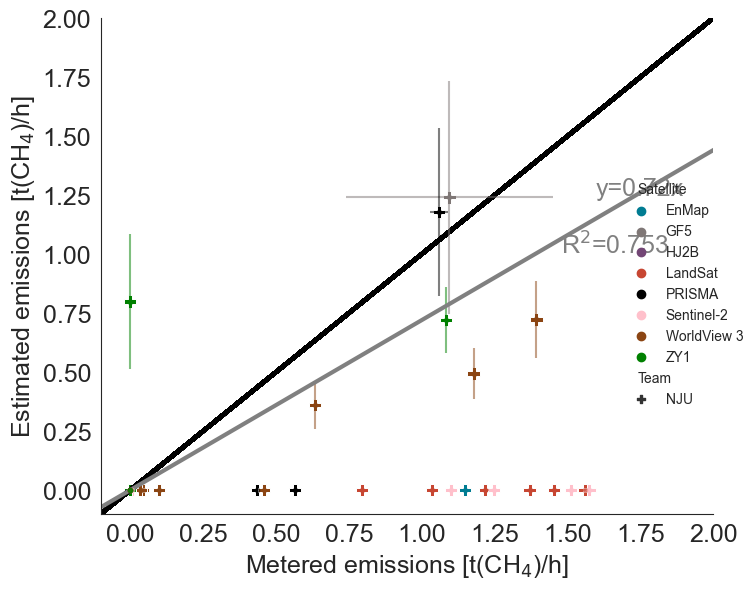

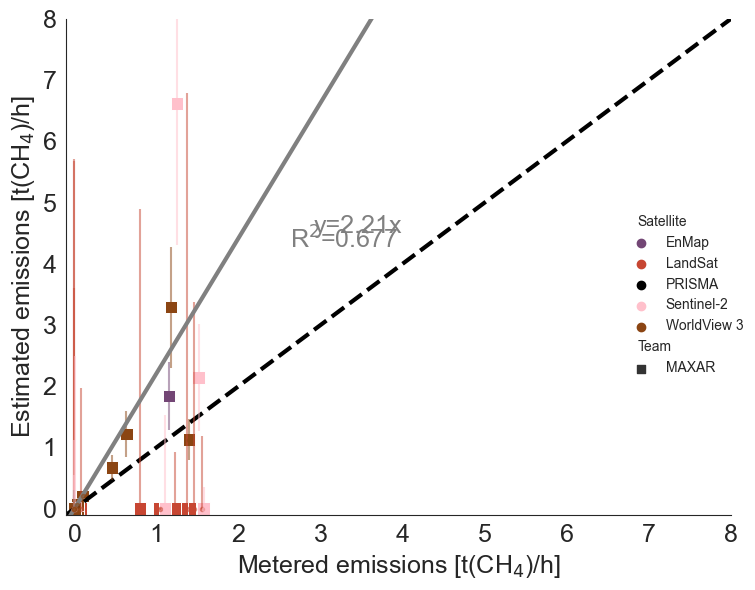

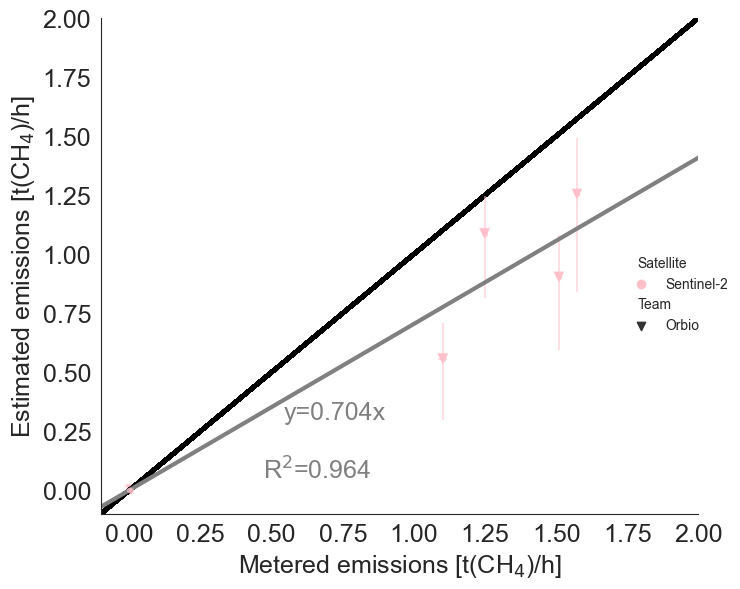

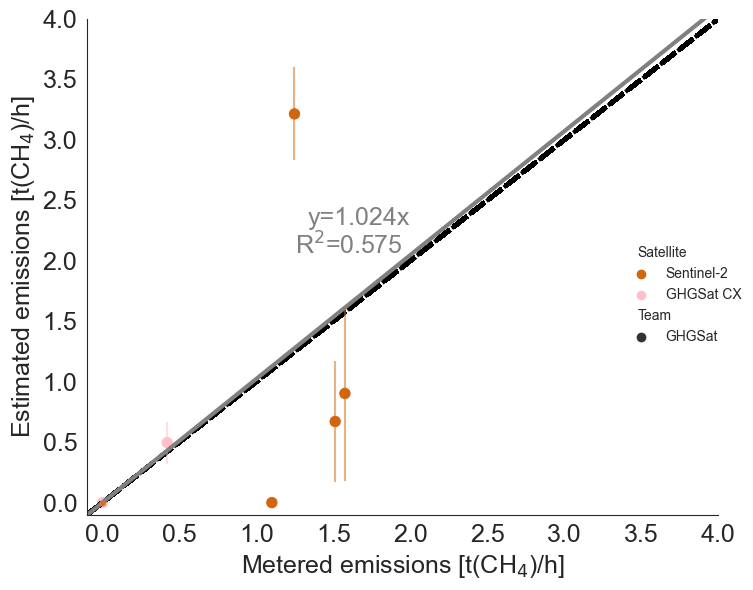

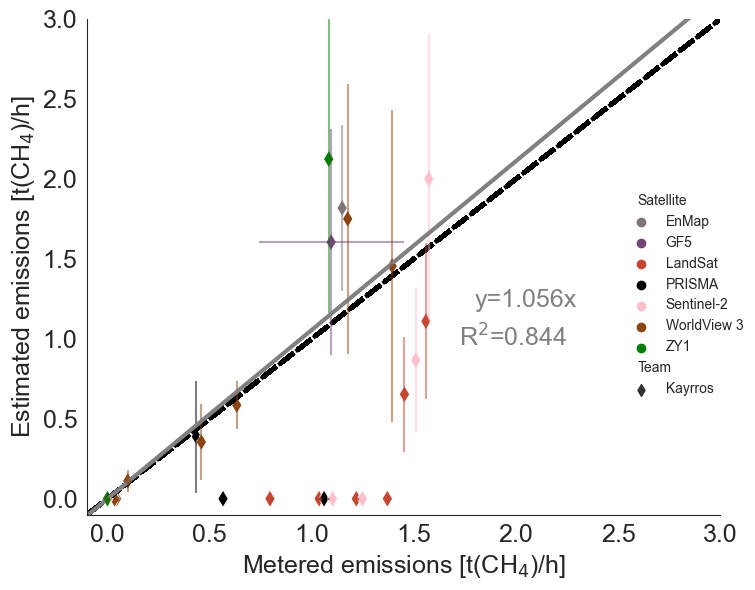

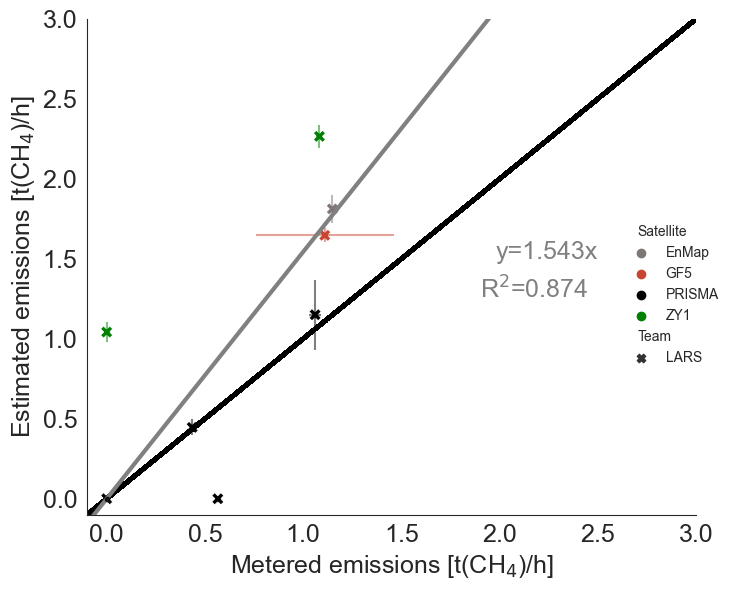

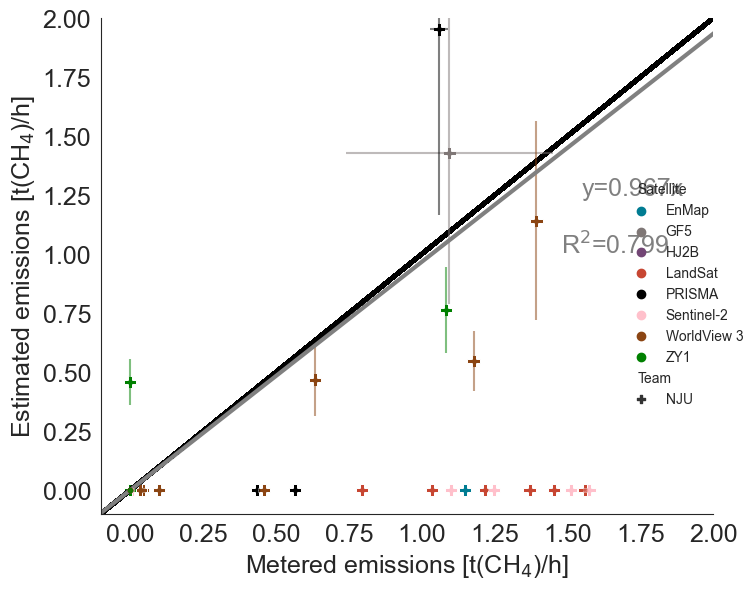

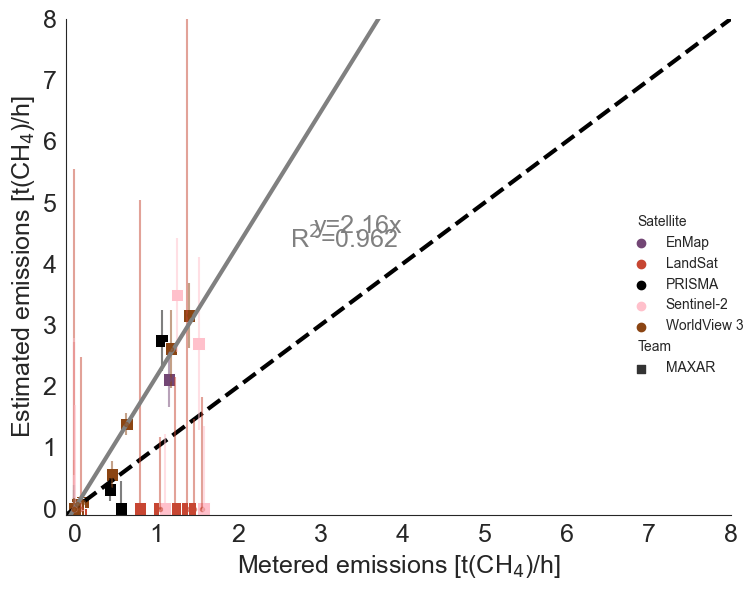

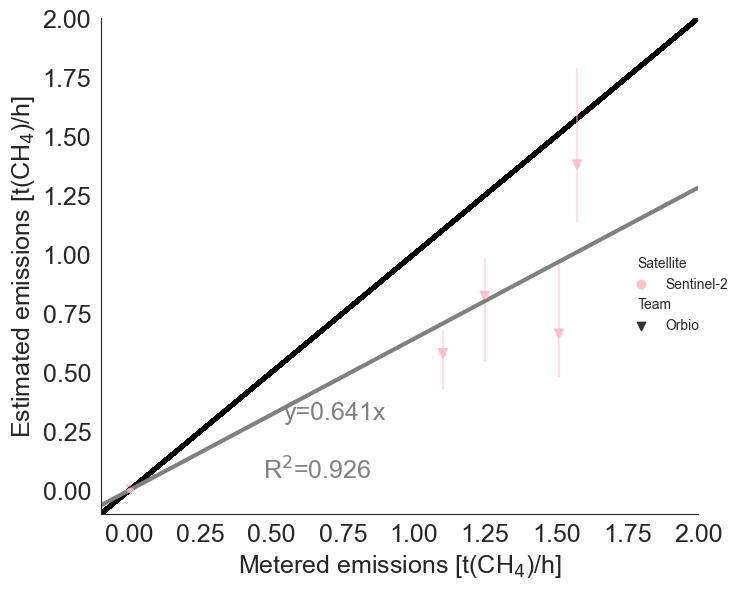

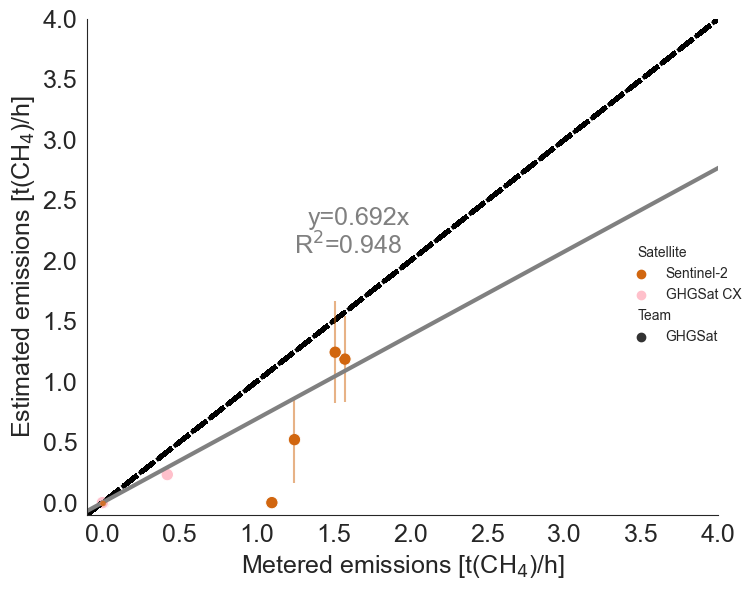

In [386]:
# Results with full QC

# Stage 1
parityPlot(filename='Satellite Kayrros stage 1 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.3, linfitTextY=1.2, team='Kayrros')
parityPlot(filename='Satellite LARS stage 1 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.5, linfitTextY=1.5, team='LARS')
parityPlot(filename='Satellite NJU stage 1 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.9, linfitTextY=1.25, team='NJU')
parityPlot(filename='Satellite MAXAR stage 1 20230509.png', satellitedata=satelliteResults, axisbound=8, linfitTextX=4, linfitTextY=4.5, team='MAXAR')
parityPlot(filename='Satellite Orbio stage 1 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.9, linfitTextY=0.3, team='Orbio')
parityPlot(filename='Satellite GHGSat stage 1 20230509.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, team='GHGSat')

# Stage 2
parityPlot(filename='Satellite Kayrros stage 2 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.3, linfitTextY=1.2, team='Kayrros', stage=2)
parityPlot(filename='Satellite LARS stage 2 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.5, linfitTextY=1.5, team='LARS', stage=2)
parityPlot(filename='Satellite NJU stage 2 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.9, linfitTextY=1.25, team='NJU', stage=2)
parityPlot(filename='Satellite MAXAR stage 2 20230509.png', satellitedata=satelliteResults, axisbound=8, linfitTextX=4, linfitTextY=4.5, team='MAXAR', stage=2)
parityPlot(filename='Satellite Orbio stage 2 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.9, linfitTextY=0.3, team='Orbio', stage=2)
parityPlot(filename='Satellite GHGSat stage 2 20230509.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, team='GHGSat', stage=2)

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 

<Figure size 640x480 with 0 Axes>

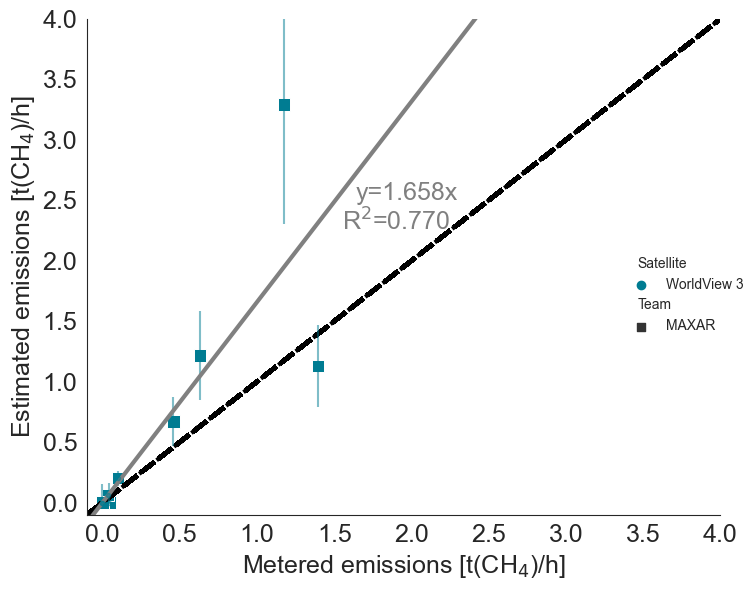

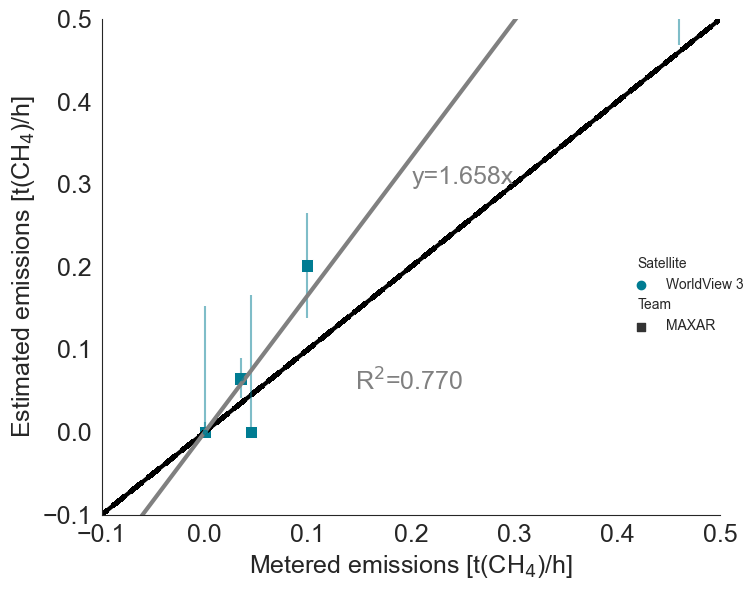

In [171]:
# Results by satellite
# With full QC

# Stage 1
parityPlot(filename='Satellite Sentinel-2 stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=8, linfitTextX=1.5, linfitTextY=6, linfitspacing=0.5, satellite='Sentinel-2')
parityPlot(filename='Satellite GHGSat stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=0.2, linfitTextY=1.6, linfitspacing=0.1, satellite='GHGSat CX', includeReg='No')
parityPlot(filename='Satellite EnMAP stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.2, linfitTextY=1.6, linfitspacing=-0.05, satellite='EnMap')
parityPlot(filename='Satellite GF5 stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.75, linfitTextY=0.4, linfitspacing=-0.05, satellite='GF5')
parityPlot(filename='Satellite LandSat stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.6, linfitTextY=0.2, linfitspacing=-0.05, satellite='LandSat')
parityPlot(filename='Satellite PRISMA stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.2, linfitTextY=0.9, linfitspacing=-0.05, satellite='PRISMA')
parityPlot(filename='Satellite WorldView 3 stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=1.7, linfitspacing=0.1, satellite='WorldView 3')
parityPlot(filename='Satellite ZY1 stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=0.5, linfitTextY=3, linfitspacing=0.1, satellite='ZY1')
parityPlot(filename='Satellite HJ2B stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, linfitspacing=0.1, satellite='HJ2B', includeReg='No')

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 obser

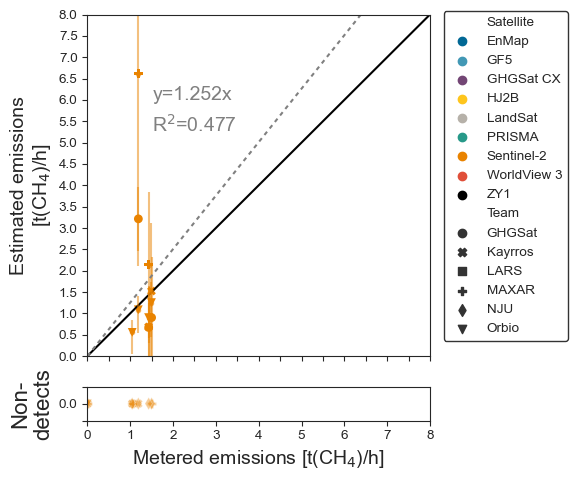

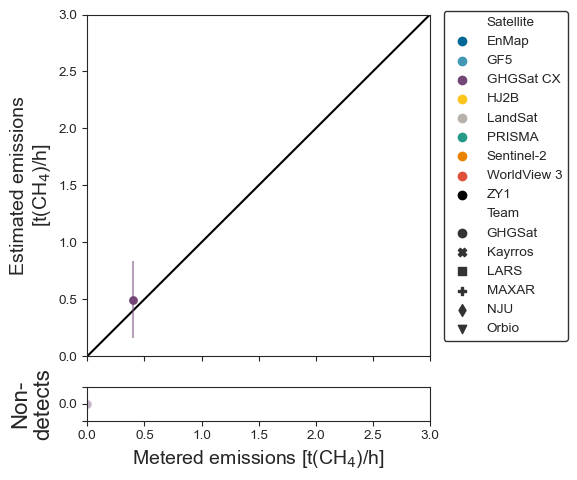

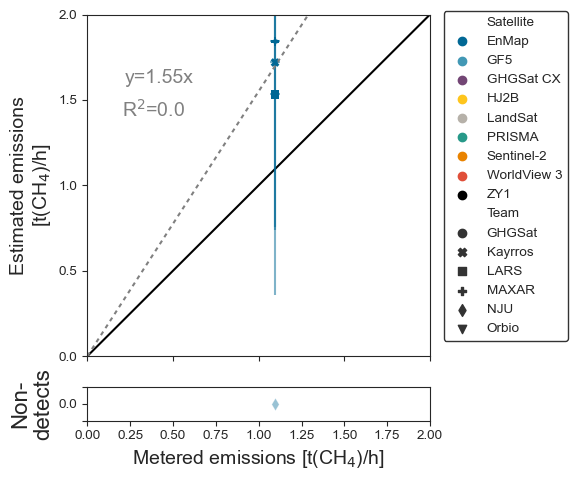

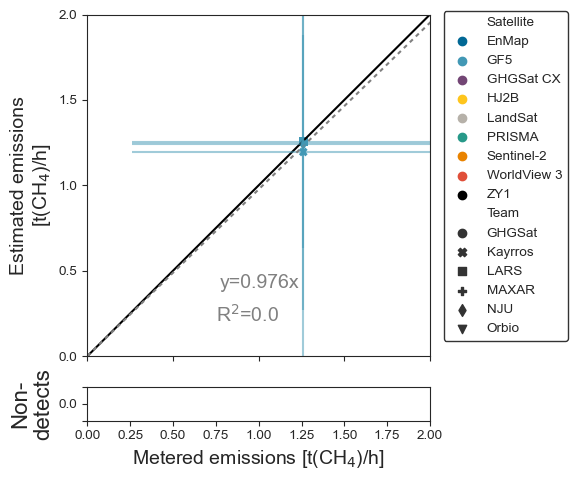

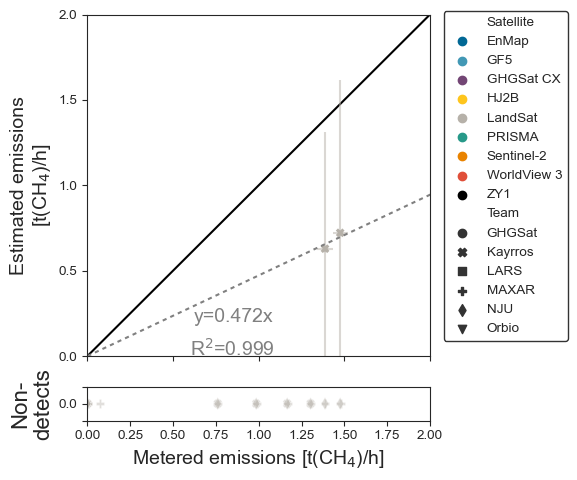

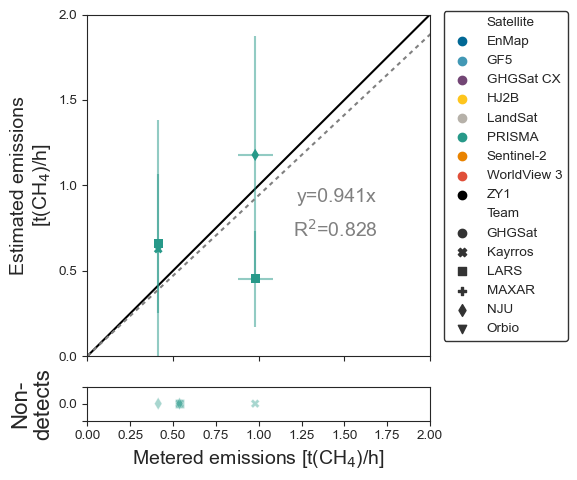

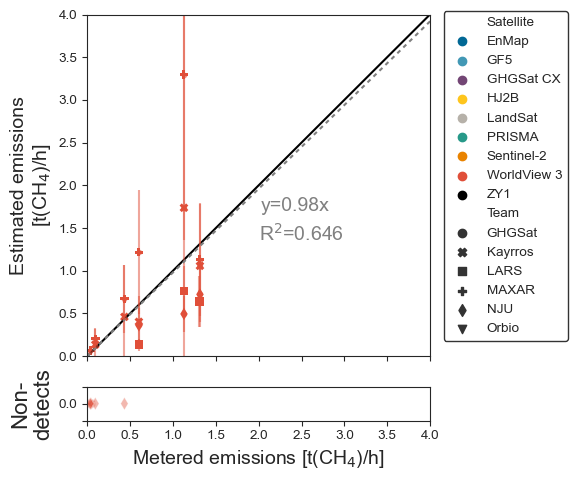

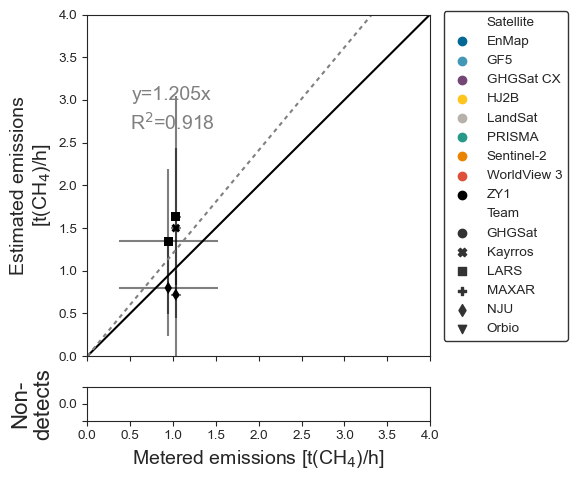

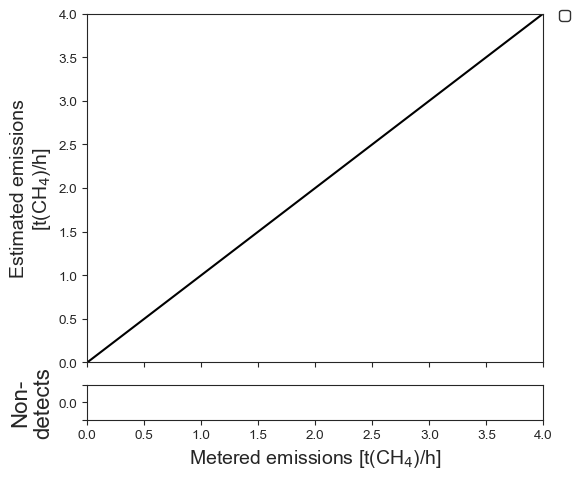

In [195]:
# Results by satellite
# With lax QC

# Stage 1
parityPlot(filename='Satellite Sentinel-2 laxqc stage 1 202305026.pdf', satellitedata=satelliteResults, axisbound=8, linfitTextX=1.5, linfitTextY=6, linfitspacing=0.5, satellite='Sentinel-2', qc='lax')
parityPlot(filename='Satellite GHGSat laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=3, linfitTextX=0.2, linfitTextY=1.6, linfitspacing=0.1, satellite='GHGSat CX', includeReg='No', qc='lax')
parityPlot(filename='Satellite EnMAP laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.2, linfitTextY=1.6, linfitspacing=-0.05, satellite='EnMap', qc='lax')
parityPlot(filename='Satellite GF5 laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.75, linfitTextY=0.4, linfitspacing=-0.05, satellite='GF5', qc='lax')
parityPlot(filename='Satellite LandSat laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.6, linfitTextY=0.2, linfitspacing=-0.05, satellite='LandSat', qc='lax')
parityPlot(filename='Satellite PRISMA laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.2, linfitTextY=0.9, linfitspacing=-0.05, satellite='PRISMA', qc='lax')
parityPlot(filename='Satellite WorldView 3 laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=1.7, linfitspacing=0.1, satellite='WorldView 3', qc='lax')
parityPlot(filename='Satellite ZY1 laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=4, linfitTextX=0.5, linfitTextY=3, linfitspacing=0.1, satellite='ZY1', qc='lax')
parityPlot(filename='Satellite HJ2B laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, linfitspacing=0.1, satellite='HJ2B', includeReg='No', qc='lax')


/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLoca

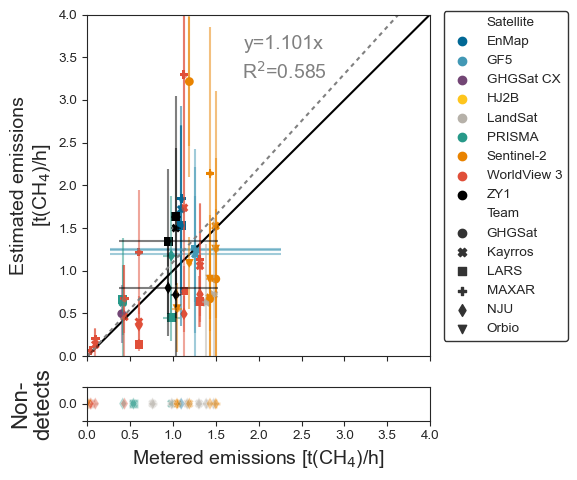

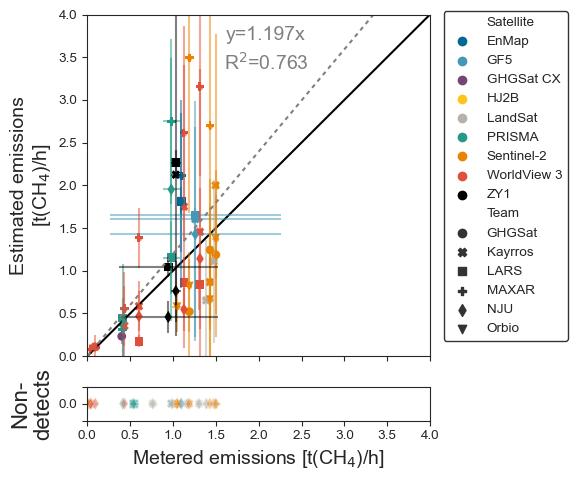

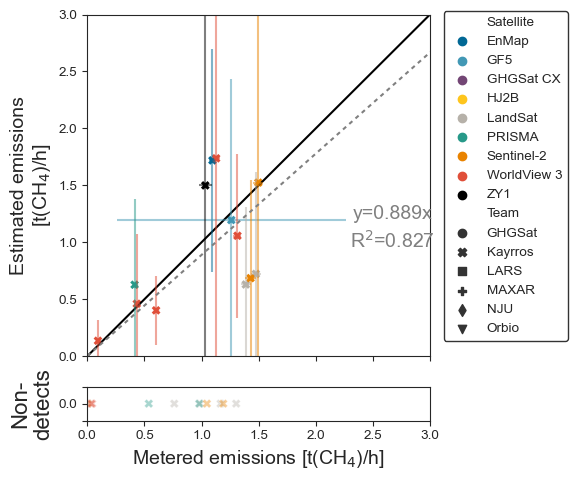

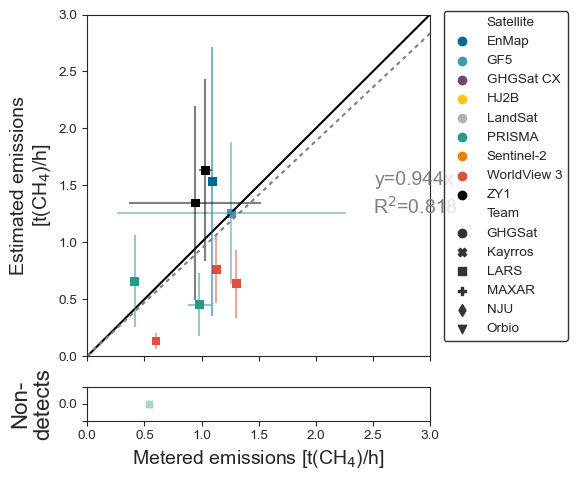

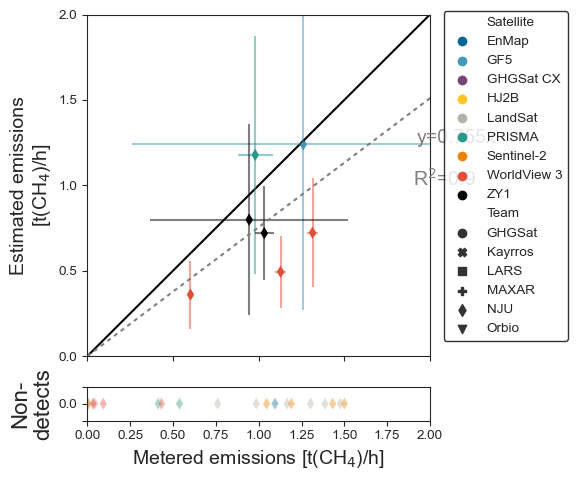

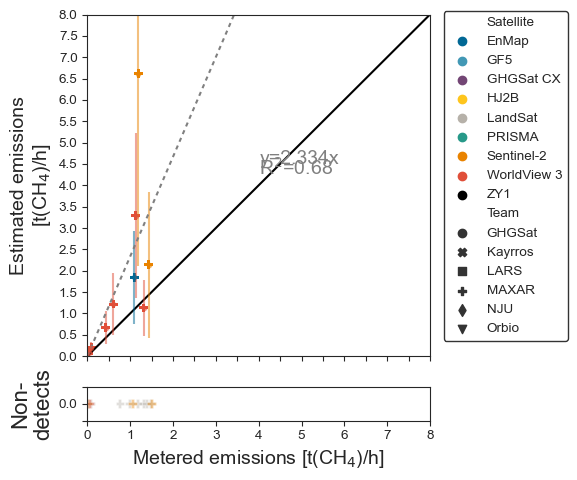

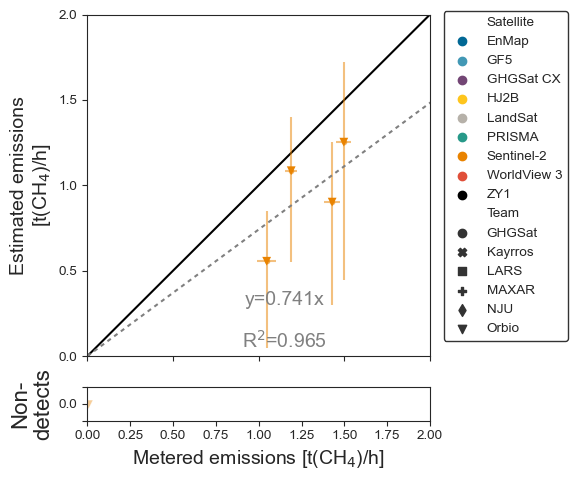

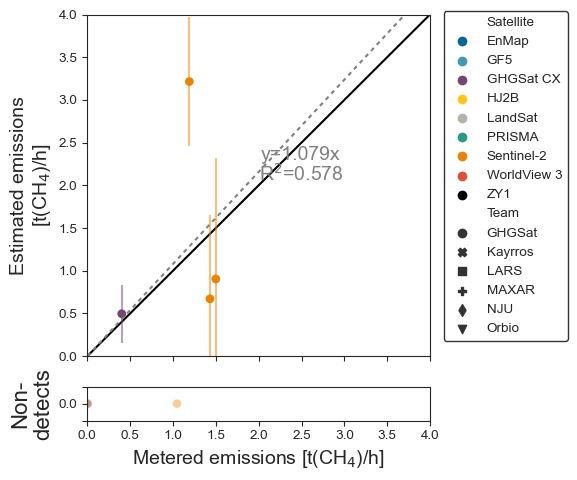

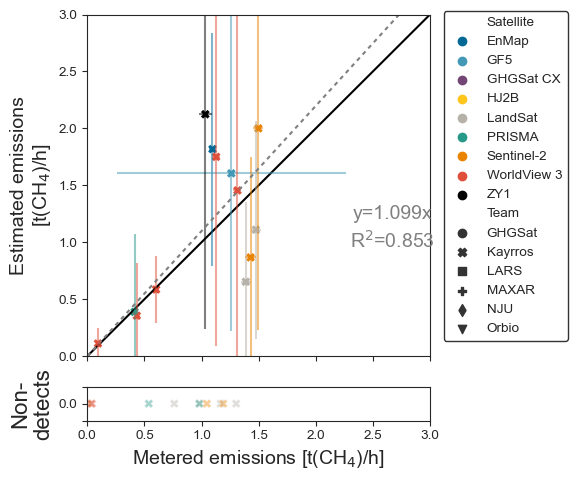

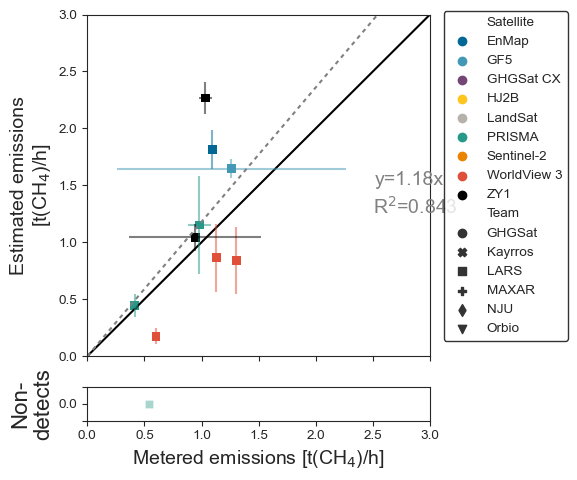

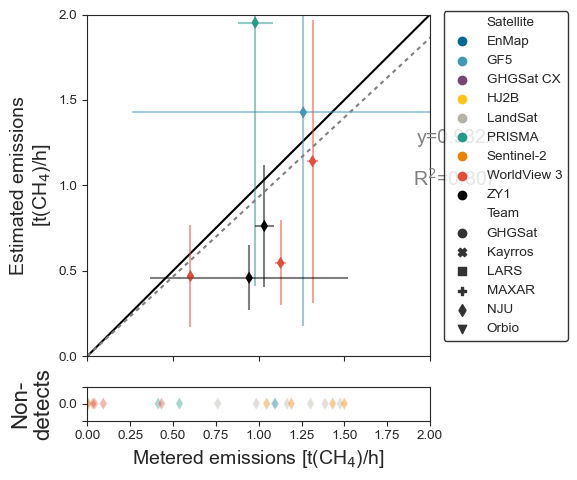

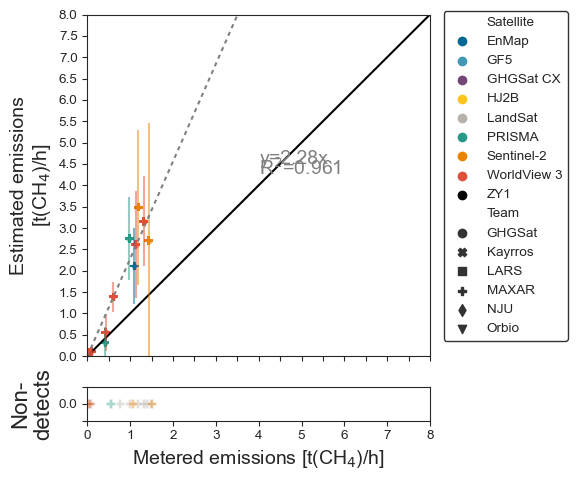

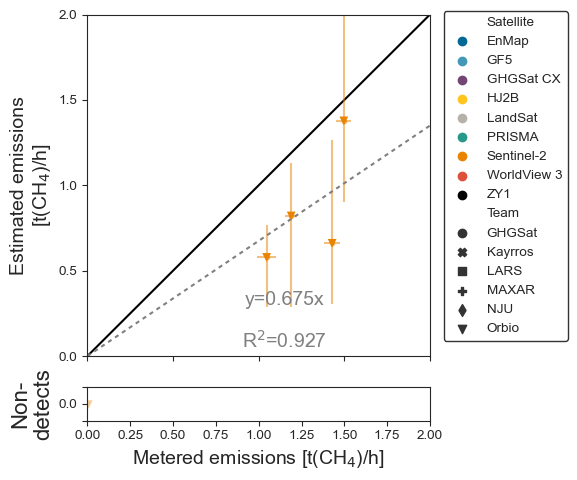

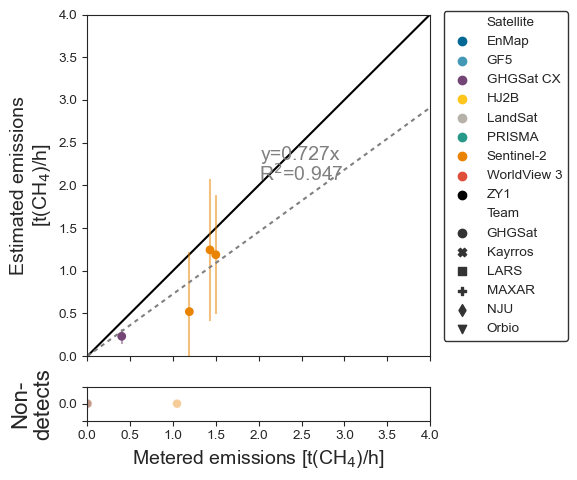

In [193]:
# Results with lax QC

# Stage 1
# parityPlot(filename='Satellite parity laxqc stage 1 20230526.png', axisbound=8, linfitTextX=3.6, linfitTextY=7.2, linfitspacing=0.5, satellitedata=satelliteResults)
parityPlot(filename='Satellite parity laxqc stage 1 zoom 20230526.pdf', axisbound=4, linfitTextX=1.8, linfitTextY=3.6, linfitspacing=0.1, satellitedata=satelliteResults, qc='lax')
#
# # Stage 2
# parityPlot(filename='Satellite parity laxqc stage 2 20230526.png', axisbound=8, linfitTextX=3.2, linfitTextY=7.4, linfitspacing=0.5, satellitedata=satelliteResults, stage=2)
parityPlot(filename='Satellite parity laxqc stage 2 zoom 20230526.pdf', axisbound=4, linfitTextX=1.6, linfitTextY=3.7, linfitspacing=0.1, satellitedata=satelliteResults, stage=2, qc='lax')


# Stage 1
parityPlot(filename='Satellite Kayrros laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.3, linfitTextY=1.2, team='Kayrros', qc='lax')
parityPlot(filename='Satellite LARS laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.5, linfitTextY=1.5, team='LARS', qc='lax')
parityPlot(filename='Satellite NJU laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.9, linfitTextY=1.25, team='NJU', qc='lax')
parityPlot(filename='Satellite MAXAR laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=8, linfitTextX=4, linfitTextY=4.5, team='MAXAR', qc='lax')
parityPlot(filename='Satellite Orbio laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.9, linfitTextY=0.3, team='Orbio', qc='lax')
parityPlot(filename='Satellite GHGSat laxqc stage 1 20230526.pdf', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, team='GHGSat', qc='lax')

# Stage 2
parityPlot(filename='Satellite Kayrros laxqc stage 2 20230526.pdf', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.3, linfitTextY=1.2, team='Kayrros', stage=2, qc='lax')
parityPlot(filename='Satellite LARS laxqc stage 2 20230526.pdf', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.5, linfitTextY=1.5, team='LARS', stage=2, qc='lax')
parityPlot(filename='Satellite NJU laxqc stage 2 20230526.pdf', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.9, linfitTextY=1.25, team='NJU', stage=2, qc='lax')
parityPlot(filename='Satellite MAXAR laxqc stage 2 20230526.pdf', satellitedata=satelliteResults, axisbound=8, linfitTextX=4, linfitTextY=4.5, team='MAXAR', stage=2, qc='lax')
parityPlot(filename='Satellite Orbio laxqc stage 2 20230526.pdf', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.9, linfitTextY=0.3, team='Orbio', stage=2, qc='lax')
parityPlot(filename='Satellite GHGSat laxqc stage 2 20230526.pdf', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, team='GHGSat', stage=2, qc='lax')


In [ ]:
parityPlot(filename='Satellite MAXAR WV3 stage 1 20230415.png'), satellitedata=satelliteResults, axisbound=4, linfitTextX=2.3, linfitTextY=2.5, team='MAXAR', satellite='WorldView 3')
parityPlot(filename='Satellite MAXAR WV3 zoom stage 1 20230415.png'), satellitedata=satelliteResults, axisbound=0.5, linfitTextX=0.3, linfitTextY=0.3, team='MAXAR', satellite='WorldView 3')
parityPlot(filename='Satellite MAXAR WV3 stage 2 20230415.png'), satellitedata=satelliteResults, axisbound=4, linfitTextX=2.3, linfitTextY=2.5, team='MAXAR', satellite='WorldView 3', stage=2)
parityPlot(filename='Satellite MAXAR WV3 zoom stage 2 20230415.png'), satellitedata=satelliteResults, axisbound=0.5, linfitTextX=0.3, linfitTextY=0.3, team='MAXAR', satellite='WorldView 3', stage=2)


Percent quantification error, Figure S2

In [155]:
# Figure S2, percent quantification error
# To produce Stage 2 estimates, switch unblindingStage from 1 to 2

def errorPlot(filename, satellitedata=satelliteResults, satellite='All', team='All', stage=1, axisbound=200, qc='default'):

    fig = plt.gcf()
    unblindingStage = stage # 1 # 2
    selectedSatellite = satellite
    selectedTeam = team

    # Filter for unblinding stage
    satellitedata = satellitedata[satellitedata['UnblindingStage']==stage]

    # Apply QC criteria
    if qc == 'default':
        satellitedata = satellitedata[satellitedata['QC']=='OK']
    elif qc == 'lax':
        satellitedata = satellitedata[satellitedata['QC_lax']=='OK']

    if satellite == 'All':
        if team == 'All':
            selectedSatelliteResults = satellitedata
            # selectedSatelliteResults = satellitedata[satellitedata['UnblindingStage']==unblindingStage]
    if (satellite != 'All') & (team != 'All'):
        selectedSatelliteResults = satellitedata[(satellitedata['Satellite']==selectedSatellite) & (satellitedata['Team']==selectedTeam)]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif satellite != 'All':
        selectedSatelliteResults = satellitedata[satellitedata['Satellite']==selectedSatellite]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif team != 'All':
        selectedSatelliteResults = satellitedata[satellitedata['Team']==selectedTeam]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]

    # Percent change
    pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='ch4_tph_mean', y='Error num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter') #, legend=False)
    # In situ wind
    # pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_ch4_mean300', y='Error in situ wind num', style='Team', hue='Satellite', s=80, kind='scatter') #, legend=False)
    # sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.8, 0.99))
    sns.set_style("white")
    plt.xlim(0,2)
    # plt.ylim(-103,150)
    pctScatterPlot._legend.set_title("Satellite")
    # mainScatterPlot._legend.draw_frame(True)
    pctScatterPlot._legend.set_frame_on(True)
    # pctScatterPlot._legend.remove()
    plt.xlabel('Metered emissions [t(CH4)/h]', fontsize=18)
    plt.ylabel('Error [%]', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams["figure.figsize"] = (6,5)
    # ax.get_yaxis().set_major_formatter(
    #     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    # ax.get_xaxis().set_major_formatter(
    #     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))# sns.set_style('darkgrid', {'legend.frameon':True})
    # plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity error stage 1 20230118.pdf', format='pdf')
    # plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity error stage 2 20230118.pdf', format='pdf')
    plt.savefig(filename, format='png')
    plt.show()

In [19]:
# errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Kayrros stage 1 20230416.png'), satellitedata=satelliteResults, team='Kayrros')

# Stage 1
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Kayrros stage 1 20230417.png'), satellitedata=satelliteResults, team='Kayrros')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors LARS stage 1 20230417.png'), satellitedata=satelliteResults, team='LARS')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors NJU stage 1 20230417.png'), satellitedata=satelliteResults, team='NJU')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors MAXAR stage 1 20230417.png'), satellitedata=satelliteResults, team='MAXAR')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Orbio stage 1 20230417.png'), satellitedata=satelliteResults, team='Orbio')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors GHGSat stage 1 20230417.png'), satellitedata=satelliteResults, team='GHGSat')

# Stage 2
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Kayrros stage 2 20230417.png'), satellitedata=satelliteResults, team='Kayrros', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors LARS stage 2 20230417.png'), satellitedata=satelliteResults, team='LARS', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors NJU stage 2 20230417.png'), satellitedata=satelliteResults, team='NJU', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors MAXAR stage 2 20230417.png'), satellitedata=satelliteResults, team='MAXAR', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Orbio stage 2 20230417.png'), satellitedata=satelliteResults, team='Orbio', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors GHGSat stage 2 20230417.png'), satellitedata=satelliteResults, team='GHGSat', stage=2)


,cr_kgh_CH4_mean300,Wind_MPS_mean60,Wind_MPS_sd60,Wind_dir_mean60,Wind_dir_sd60
Sentinel-2,3.5,4.3,0.7,57.0,15.4
Landsat 8,4.2,4.0,0.9,48.8,7.8
PRISMA,4.5,3.7,0.7,38.9,5.2
WorldView 3,4.0,3.9,0.7,243.0,10.4
GHGSat C2,4.2,2.0,0.4,264.1,10.8


Metered emission rate, wind speed, and wind direction for emissions from Figure 2

<Figure size 432x288 with 0 Axes>

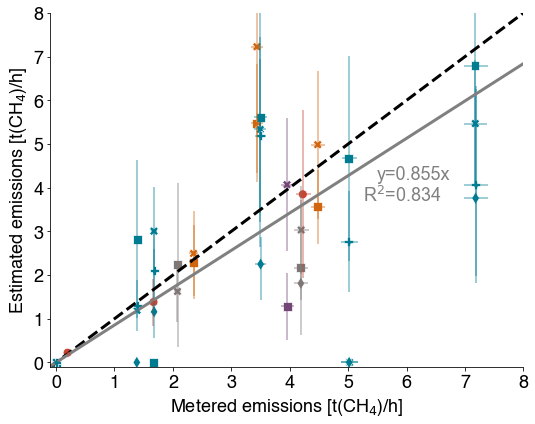

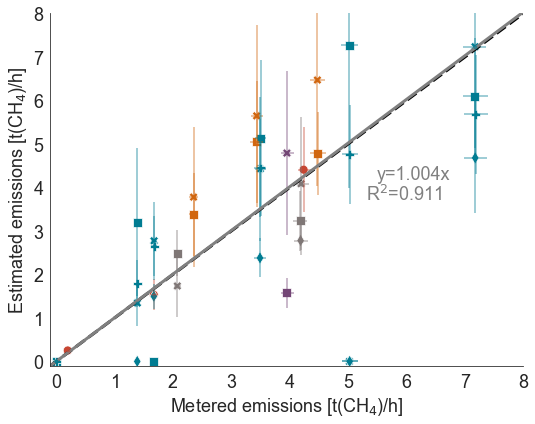

In [37]:
# Key values for Figure 2

key_fig2_cols = ["cr_kgh_ch4_mean300", "Wind_MPS_mean60", "Wind_MPS_sd60", "Wind_dir_mean60", "Wind_dir_sd60"]
Figure2_vals = pd.DataFrame(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-27 18:34:57+00:00") & (selectedSatelliteResults["OperatorSet"]=="Sentinel-2/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-21 18:10:37+00:00") & (selectedSatelliteResults["OperatorSet"]=="Landsat 8/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-21 18:23:12+00:00") & (selectedSatelliteResults["OperatorSet"]=="PRISMA/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-23 18:40:53+00:00") & (selectedSatelliteResults["OperatorSet"]=="WV3/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-24 17:35:19+00:00") & (selectedSatelliteResults["OperatorSet"]=="GHGSat C2/GHGSat"), key_fig2_cols])
Figure2_vals.index = ["Sentinel-2", "Landsat 8", "PRISMA", "WorldView 3", "GHGSat C2"]
np.round(Figure2_vals, 1)

Generate parity charts, including Figure 3

In [ ]:
# Figure 3 and Figure S1 (to generate 95% CI, set yCImult = 1.96)
# Plots for stages 1 and 2
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 1 20230118.pdf', satellitedata=satelliteResults, stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 2 20230118.pdf', satellitedata=satelliteResults, stage=2)
# parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 1 95% CI 20230118.pdf', satellitedata=satelliteResults, stage=1)
# parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 2 95% CI 20230118.pdf', satellitedata=satelliteResults, stage=2)

In [ ]:
# Figure S4, parity charts by team

parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Kayrros 20230116c.pdf', satellitedata=satelliteResults, team='Kayrros', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity SRON 20230116c.pdf', satellitedata=satelliteResults, team='SRON', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Harvard 20231016c.pdf', satellitedata=satelliteResults, team='Harvard', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity LARS 20230116c.pdf', satellitedata=satelliteResults, team='LARS', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity GHGSat 20230116c.pdf', satellitedata=satelliteResults, team='GHGSat', stage=1)

In [36]:
# Figure S5, parity charts by satellite

parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Sentinel-2 20230116c.pdf', satellitedata=satelliteResults, satellite='Sentinel-2', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Landsat 8 20230116c.pdf', satellitedata=satelliteResults, satellite='Landsat 8', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity PRISMA 20230116c.pdf', satellitedata=satelliteResults, satellite='PRISMA', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity GHGSat C2 20230116c.pdf', satellitedata=satelliteResults, satellite='GHGSat C2', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity WV3 20230116c.pdf', satellitedata=satelliteResults, satellite='WV3', stage=1)

count    44.000000
mean      0.112608
std       0.006102
min       0.101474
25%       0.109074
50%       0.112926
75%       0.116130
max       0.127175
dtype: float64

Percent error summary stats

In [272]:
unblindingStage = 1 # 2
# Remove LARS WV3 quantification, which was submitted off-cycle
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS')]
# Exclude Maxar as well
# selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS') & (satelliteResults['Team'] != 'MAXAR')]


# Min and max % error in estimates
selectedSatelliteResults.loc[selectedSatelliteResults['Error num'] > non_detect_pct_err_bound, 'Error num'].describe()

count     44.000000
mean      28.782045
std       90.378411
min      -56.192862
25%      -34.130838
50%        4.046990
75%       55.216232
max      456.004798
Name: Error num, dtype: float64

In [273]:
# Error statistics, percent of detected emissions with Stage 1 absolute error below 50%
# selectedSatelliteResults.loc[satelliteResultsNoLARSWV3['Error num'] > non_detect_pct_err_bound, 'Error num'].describe()
detectedResults = selectedSatelliteResults.loc[selectedSatelliteResults['Error num'] > non_detect_pct_err_bound, 'Error num'].size
detectedResultsUnder50 = (abs(selectedSatelliteResults.loc[selectedSatelliteResults['Error num'] > non_detect_pct_err_bound, 'Error num']) <= 50).sum()
detectedResultsUnder50, detectedResults, detectedResultsUnder50/detectedResults

(24, 44, 0.5454545454545454)

Comparison of Stage 1 and 2 quantification


In [328]:
# Remove LARS WV3 quantification, which was submitted off-cycle
selectedSatelliteResults = satelliteResults[satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS']
# Exclude Maxar as well
# selectedSatelliteResults = satelliteResults[(satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS') & (satelliteResults['Team'] != 'MAXAR')]
stage1Ests = selectedSatelliteResults.loc[(selectedSatelliteResults['UnblindingStage'] == 1), ['SatelliteTeam', 'Estimate (TPH) num']].set_index('SatelliteTeam')
stage2Ests = selectedSatelliteResults.loc[(selectedSatelliteResults['UnblindingStage'] == 2), ['SatelliteTeam', 'Estimate (TPH) num']].set_index('SatelliteTeam')

stage2pctdiff = 100*(stage2Ests - stage1Ests)/stage1Ests
stage2pctdiff[stage2pctdiff.isnull().values == False].describe()

,Estimate (TPH) num
count,44.000000
mean,12.763889
std,49.377152
min,-83.794712
25%,-22.532003
50%,12.172105
75%,32.165446
max,179.713929


In [306]:
# Wind speed stage 1 to 2 percent difference
stage1Winds = selectedSatelliteResults.loc[(selectedSatelliteResults['UnblindingStage'] == 1), ['SatelliteTeam', 'Wind speed est num']].set_index('SatelliteTeam')
stage2Winds = selectedSatelliteResults.loc[(selectedSatelliteResults['UnblindingStage'] == 2), ['SatelliteTeam', 'Wind speed est num']].set_index('SatelliteTeam')

stage2pctdiffWinds = 100*(stage2Winds - stage1Winds)/stage1Winds
stage2pctdiffWinds[(stage2pctdiffWinds.isnull().values == False) & (stage2pctdiffWinds < np.inf)].describe()

,Wind speed est num
count,65.000000
mean,48.563673
std,135.729758
min,-84.054054
25%,-32.236842
50%,13.817671
75%,64.022304
max,697.557441


Confidence interval calibration assessment

In [330]:
# Fraction estimates with CI overlapping parity line
# For 1-sigma results, update the yCImult parameter to 1
unblindingStage = 2 # 2
CI_overlapping_parity = selectedSatelliteResults.loc[(selectedSatelliteResults['UnblindingStage'] == unblindingStage) & (selectedSatelliteResults['Error num'] > non_detect_pct_err_bound), 'within CI']==True
np.sum(CI_overlapping_parity)/CI_overlapping_parity.size


1.0

In [332]:
CI_overlapping_parity.size

44

Parity linear regression results from Figure 3

In [218]:
# Linear regression for Stage 1 satellite data, forced zero intercept, excluding non-detects and LARS WV3 off-cycle quantification estimates
unblindingStage = 2 # 1, 2
floorQuantificationEstimate = 0 # Exclude all emissions less than or equal to this from the regression analysis

# selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS')]
# Exclude Maxar
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS') & (satelliteResults['Team'] != 'MAXAR')]
# Maxar-only
# selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team'] == 'MAXAR')]
regData = selectedSatelliteResults.loc[(selectedSatelliteResults['Estimate (TPH) num'] > 0), ['ch4_tph_mean', 'Estimate (TPH) num']]
regData.columns = ['x', 'y']

include_intercept=False # True False
# X = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (TPH) num'] > floorQuantificationEstimate), 'ch4_tph_mean']).reshape(-1,1)
# y = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (TPH) num'] > floorQuantificationEstimate), 'Estimate (TPH) num']).reshape(-1,1)
selectedSatelliteResults
model = smf.ols(formula="y ~ x + 0", data=regData)
result = model.fit()
# result.summary()
results_as_html_main = result.summary().tables[1].as_html()
results_as_html_r2 = result.summary().tables[0].as_html()
# results_as_html
results_main = pd.read_html(results_as_html_main, header=0, index_col=0)[0]
results_r2_and_more = pd.read_html(results_as_html_r2, header=0, index_col=0)[0]
results_r2 = str(np.abs(float(results_r2_and_more.columns[2]))) # Prevent the possibility of a -0 R squared by doing absolute value
results_coeff = results_main['coef']# reg_stage1 = LinearRegression(fit_intercept=include_intercept).fit(X, y)
results_r2

'0.828'

In [213]:
# Regression coefficient table
results_main


,coef,std err,t,P>|t|,[0.025,0.975]
x,2.2805,0.145,15.735,0.0,1.958,2.603


Percent error values from GHGSat

In [72]:
# GHGSat errors
selectedSatelliteErrGHGSat = (satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > non_detect_pct_err_bound) & (satelliteResults['Team'] == 'GHGSat'), 'Error num'])
selectedSatelliteErrGHGSat

Fraction of New Mexico Permian emissions satellites would see, discussed in SI, Section S5

In [74]:
# Analysis of data from Sherwin et al. 2023
# Data reproduced with permission
# https://www.nature.com/articles/s41598-023-30761-2/
# Discussed further in the SI, Section S5

176.928

In [370]:
# Read in and average CDFs

cdf_filepath = '/Users/evansherwin/PycharmProjects/MethaneDistributions/CDF_data/'
def readAndAverageCDFs (filename_stub):
    cdf_1 = pd.read_csv(cdf_filepath + filename_stub + '_1.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_2 = pd.read_csv(cdf_filepath + filename_stub + '_2.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_3 = pd.read_csv(cdf_filepath + filename_stub + '_3.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_4 = pd.read_csv(cdf_filepath + filename_stub + '_4.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_5 = pd.read_csv(cdf_filepath + filename_stub + '_5.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_6 = pd.read_csv(cdf_filepath + filename_stub + '_6.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_7 = pd.read_csv(cdf_filepath + filename_stub + '_7.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_8 = pd.read_csv(cdf_filepath + filename_stub + '_8.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_9 = pd.read_csv(cdf_filepath + filename_stub + '_9.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_10 = pd.read_csv(cdf_filepath + filename_stub + '_10.csv', low_memory=False, na_filter=False).apply(pd.to_numeric, errors='coerce')
    cdf_final = (cdf_1 + cdf_2 + cdf_3 + cdf_4 + cdf_5 + cdf_6 + cdf_7 + cdf_8 + cdf_9 + cdf_10)/10
    return cdf_final

# Kairos Permian data
kairosPermianProductionDistribution = readAndAverageCDFs('Kairos PermianPermian basin_production_20230329b')

,Emission magnitude [kgh],Log emission magnitude [log(kgh)],Cumulative emissions [kgh],Cumulative aerial emissions [kgh],Cumulative partial emissions [kgh],Cumulative simulated emissions [kgh],Cumulative fraction of sites Rutherford,Emission magnitude Rutherford [kgh],Log emission magnitude Rutherford [kgh],Cumulative emissions fraction Rutherford [%],...,Cumulative emissions fraction aerial [%],Cumulative emissions fraction [%],Log cumulative emissions fraction,Cumulative fraction of sites,Cumulative fraction of sites inc partial detect,Log cumulative fraction of sites,Fraction of sites emitting at or above this level,Fraction of aerial detect sites at or above this level,Cumulative fraction missed partial detect sites,Partial detection correction [%]
0,0.000000,-inf,110513.120227,87974.216429,4745.611126,23423.401212,NaN,0.003448,-2.462417,0.212676,...,0.794989,1.000000,NaN,0.000055,0.000055,0.000000,1.000000,0.070937,0.005346,0.0
1,0.000000,-inf,110513.120227,87974.216429,4745.611126,23423.397764,NaN,0.003448,-2.462417,0.212676,...,0.794989,1.000000,NaN,0.000111,0.000110,-0.000024,0.999945,0.070937,0.005346,0.0
2,0.000000,-inf,110513.120227,87974.216429,4745.611126,23423.394316,NaN,0.003448,-2.462417,0.212676,...,0.794989,1.000000,NaN,0.000166,0.000166,-0.000048,0.999889,0.070937,0.005346,0.0
3,0.000000,-inf,110513.120227,87974.216429,4745.611126,23423.390868,NaN,0.003448,-2.462417,0.212676,...,0.794989,1.000000,NaN,0.000222,0.000221,-0.000072,0.999834,0.070937,0.005346,0.0
4,0.000000,-inf,110513.120227,87974.216429,4745.611126,23423.387420,NaN,0.003448,-2.462417,0.212675,...,0.794989,1.000000,NaN,0.000277,0.000276,-0.000096,0.999779,0.070937,0.005346,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18025,1695.514497,3.222757,11097.695314,12793.209811,0.000000,804.641058,NaN,119.983167,2.077857,0.007313,...,0.115025,0.099796,NaN,0.999778,0.999779,-3.559341,0.000287,0.025338,0.000000,0.0
18026,1900.715362,3.271002,9196.979953,11097.695314,0.000000,679.780350,NaN,124.860708,2.094168,0.006179,...,0.099739,0.082660,NaN,0.999834,0.999834,-3.656251,0.000229,0.025282,0.000000,0.0
18027,2208.771538,3.332224,6988.208415,9196.979953,0.000000,542.996217,NaN,136.784133,2.124547,0.004937,...,0.082612,0.062768,NaN,0.999889,0.999890,-3.781190,0.000171,0.025227,0.000000,0.0
18028,2784.687694,3.425133,4203.520721,6988.208415,0.000000,366.492625,NaN,176.503592,2.195680,0.003332,...,0.062732,0.037745,NaN,0.999945,0.999945,-3.957281,0.000113,0.025171,0.000000,0.0


In [380]:
kairosPermianProductionDistribution.loc[(kairosPermianProductionDistribution['Emission magnitude [kgh]'] >= 1000), 'Cumulative emissions fraction [%]'].max(), kairosPermianProductionDistribution.loc[(kairosPermianProductionDistribution['Emission magnitude [kgh]'] >= 200), 'Cumulative emissions fraction [%]'].max(), kairosPermianProductionDistribution.loc[(kairosPermianProductionDistribution['Emission magnitude [kgh]'] >= 30), 'Cumulative emissions fraction [%]'].max()

(0.19513613231389101, 0.6221792801183209, 0.8327762345661499)

In [ ]:
permianPlumes = pd.read_csv('/Users/evansherwin/PycharmProjects/SatelliteTesting/Data/Chen, Sherwin et al 2022 plume_table.csv')
permianPlumes['emissions_kgh'] = permianPlumes['wind_independent_emission_rate_kghmps']*permianPlumes['wind_mps']
permianPlumes['emissions>=5tph'] = permianPlumes['emissions_kgh'] >= 5000
permianPlumes['emissions>=1tph'] = permianPlumes['emissions_kgh'] >= 1000
permianPlumes['emissions>=0_5tph'] = permianPlumes['emissions_kgh'] >= 500
permianPlumes['emissions>=0_1tph'] = permianPlumes['emissions_kgh'] >= 100
emissions_gr_cols = ['emissions>=5tph', 'emissions>=1tph', 'emissions>=0_5tph', 'emissions>=0_1tph']

In [75]:
# Plumes detected in each case
np.sum(permianPlumes[emissions_gr_cols])

emissions>=5tph      0.005542
emissions>=1tph      0.058942
emissions>=0_5tph    0.129975
emissions>=0_1tph    0.595466
dtype: float64

In [76]:
# Estimated total New Mexico Permian emissions
total_NM_Permian_emissions = 194 # t/h
surveyed_NM_Permian_asset_frac = 0.912 # Fraction of active wells surveyed
surveyed_NM_Permian_emissions = total_NM_Permian_emissions*surveyed_NM_Permian_asset_frac
surveyed_NM_Permian_emissions

emissions>=5tph      0.191452
emissions>=1tph      0.468582
emissions>=0_5tph    0.607410
emissions>=0_1tph    0.891211
dtype: float64

In [ ]:
# Fraction of plumes detected in each case
np.mean(permianPlumes[emissions_gr_cols])

In [70]:
# Fraction of total emissions volume detected in each case
# Assumes 4 measurements per asset, the average across the campaign, to account for persistence
measurements_per_asset = 4
# np.sum(permianPlumes[emissions_gr_cols].multiply(permianPlumes['emissions_kgh'], axis=0))/np.sum(permianPlumes['emissions_kgh'])
np.sum(permianPlumes[emissions_gr_cols].multiply(permianPlumes['emissions_kgh'], axis=0))/(measurements_per_asset*surveyed_NM_Permian_emissions*kg_per_t)

86    -14.080435
87    103.445597
88     -6.299117
89   -100.000000
Name: Error num, dtype: float64

Quantification accuracy for the smallest Sentinel-2 release

In [153]:
# Quantification accuracy for the smallest Sentinel-2 release
satelliteResults.loc[(satelliteResults['Stanford_timestamp'] == '2021-11-03 18:25:01+00:00') & (satelliteResults['UnblindingStage'] == 1), 'Error num']


,count,min,mean,max,std
Satellite,,,,,
GHGSat C2,3,-8.209268,7.946916,27.998210,18.415327
Landsat 8,5,-33.561941,-11.055090,19.878627,20.607909
PRISMA,6,6.854812,44.498127,64.470808,20.414444
Sentinel-2,16,-34.762921,19.288769,130.784948,43.470432
WV3,2,-60.065091,-19.399713,21.265665,57.509529


Error statistics by satellite and team, in Tables S5 and S6

In [268]:
# Error statistics by satellite
# Table S5
unblindingStage = 1 # 1 # 2
# Select satellite results for the correct unblinding stage, excluding non-detects and LARS WV3 estimates
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > non_detect_pct_err_bound) & (satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS')]
# x='cr_kgh_ch4_mean300', y='Estimate (KGH) num' 'Error num'
selectedSatelliteResults.groupby('Satellite')['Error num'].agg(['count', 'min', 'mean', 'max', 'std'])

,count,min,mean,max,std
Satellite,,,,,
EnMap,3,39.965856,55.028021,68.192711,14.208770
GF5,3,-5.174159,-2.389162,-0.390017,2.487001
GHGSat CX,1,23.557542,23.557542,23.557542,NaN
HJ2B,0,NaN,NaN,NaN,NaN
LandSat,2,-54.655226,-52.865722,-51.076218,2.530741
PRISMA,4,-53.835983,19.316350,59.237613,51.601751
Sentinel-2,11,-53.129656,38.485287,456.004798,152.977044
WorldView 3,14,-56.192862,32.773727,192.018915,74.213356
ZY1,6,-30.279331,38.538595,131.219147,57.750575


In [270]:
# Table S6
# Error statistics by team
# Select satellite results for the correct unblinding stage, excluding non-detects and LARS WV3 estimates
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > non_detect_pct_err_bound) & (satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS')]
selectedSatelliteResults.groupby('Team')['Error num'].agg(['count', 'min', 'mean', 'max', 'std'])

,count,min,mean,max,std
Team,,,,,
GHGSat,4,-53.129656,25.157233,169.991186,102.186808
Kayrros,14,-54.655226,12.601060,131.219147,53.891577
LARS,6,-53.835983,24.247687,59.237613,43.939944
MAXAR,9,-14.122414,124.575744,456.004798,136.346712
NJU,7,-56.192862,-24.051313,20.261862,26.812413
Orbio,4,-46.937690,-27.235607,-8.780418,17.714948


Wind speed parity chart

<Figure size 800x400 with 0 Axes>

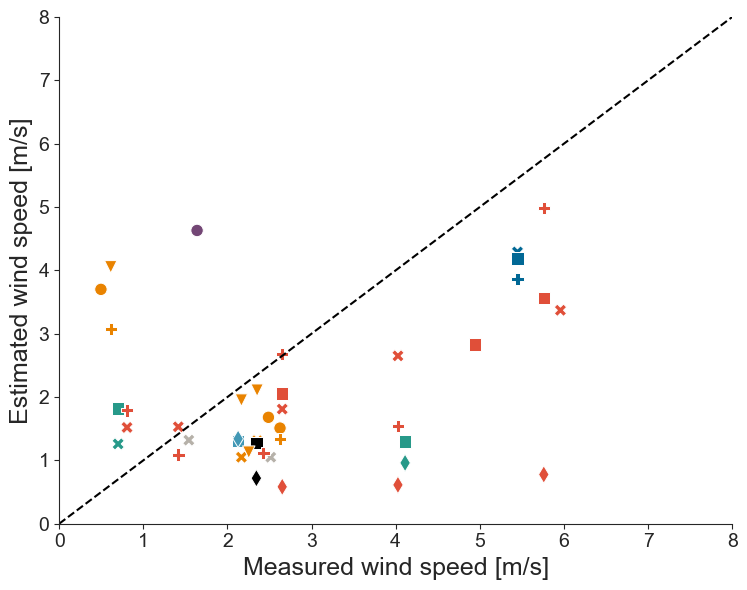

In [333]:
# Figure S3, wind speed parity chart


fig = plt.gcf()
#fig.set_size_inches(100, 8)

slctMarkers = markers.tolist()
# slctColors = colors[[4, 1, 2, 0, 3]] # [[0, 3, 1, 2, 4]]
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) &
                                            (satelliteResults['Error num'] > non_detect_pct_err_bound) &
                                            (np.isnan(satelliteResults['Error num']) == False)]

unblindingStage = 1 # 1 # 2
# selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
StanfordPalette = sns.set_palette(sns.color_palette(colors))
# slctMarkers = markers[teamPos].tolist()

mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='average_windspeed', y='Wind speed est num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05)

lims = [0, 8]
plt.plot(lims, lims, '--', color='black')
sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))

plt.xlim(lims[0],lims[1]) #10000
plt.ylim(lims[0],lims[1]) #10000
mainScatterPlot._legend.remove()
# plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0)#, title_fontsize= 'large')
# mainScatterPlot._legend.set_frame_on(True)

plt.xlabel('Measured wind speed [m/s]', fontsize=18)
plt.ylabel('Estimated wind speed [m/s]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams["figure.figsize"] = (6,5)

sns.set_style("ticks") # "whitegrid" "white"
plt.tight_layout()
plt.savefig(pathlib.PurePath('02_figures', 'Satellite wind parity 20230531.pdf'), format='pdf')
# plt.show()


In [24]:
# np.isnan(satelliteResults['Error num'])
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) &
                                            (satelliteResults['Error num'] > non_detect_pct_err_bound + 0.0000001) &
                                            (np.isnan(satelliteResults['Error num']) == False)]

selectedSatelliteResults.loc[(selectedSatelliteResults['Team'] == 'NJU') & (selectedSatelliteResults['Satellite'] == 'LandSat'), 'Error num']

Series([], Name: Error num, dtype: float64)

Percent quantification error, Figure S2

<Figure size 600x500 with 0 Axes>

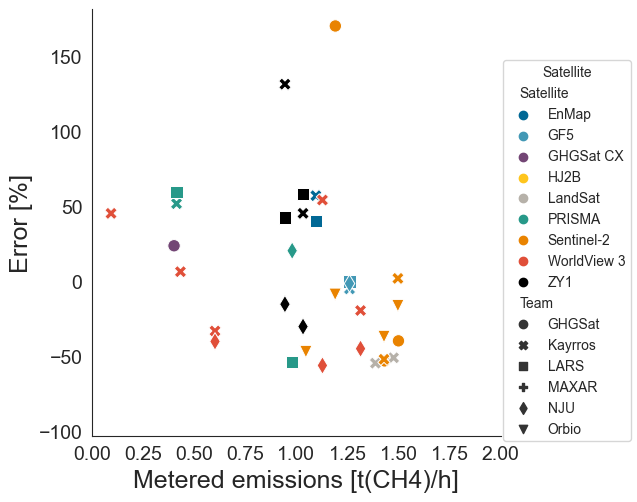

In [369]:
# Figure S2, percent quantification error
# To produce Stage 2 estimates, switch unblindingStage from 1 to 2

fig = plt.gcf()

unblindingStage = 1 # 2
slctMarkers = markers.tolist()
# slctColors = colors[[4, 1, 2, 0, 3]] # [[0, 3, 1, 2, 4]]
# selectedSatelliteResults = satelliteResults

StanfordPalette = sns.set_palette(sns.color_palette(colors))
# sns.set_palette(sns.color_palette(slctColors)) # colors
# Remove LARS WV3 results and zeros
# selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > non_detect_pct_err_bound) & (satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS')]
# Exclude Maxar as well
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > non_detect_pct_err_bound) & (satelliteResults['SatelliteTeam'] != 'WorldView 3/LARS') & (satelliteResults['Team'] != 'MAXAR')]

# Percent change
pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='ch4_tph_mean', y='Error num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter') #, legend=False)
# In situ wind
# pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_ch4_mean300', y='Error in situ wind num', style='Team', hue='Satellite', s=80, kind='scatter') #, legend=False)
# sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.8, 0.99))
sns.set_style("white")
plt.xlim(0,2)
plt.ylim(-103)
pctScatterPlot._legend.set_title("Satellite")
# mainScatterPlot._legend.draw_frame(True)
pctScatterPlot._legend.set_frame_on(True)
# pctScatterPlot._legend.remove()
plt.xlabel('Metered emissions [t(CH4)/h]', fontsize=18)
plt.ylabel('Error [%]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams["figure.figsize"] = (6,5)
# ax.get_yaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_xaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))# sns.set_style('darkgrid', {'legend.frameon':True})
# plt.savefig(pathlib.PurePath('02_figures', 'Satellite parity error with Maxar stage ' + str(unblindingStage) +' 20230531.pdf'), format='pdf')
plt.savefig(pathlib.PurePath('02_figures', 'Satellite parity error no Maxar stage ' + str(unblindingStage) + ' 20230531.pdf'), format='pdf')
plt.show()

Quantification error statistics by averaging period, Table S7

In [51]:
# Table S7
# Quantification error statistics by averaging period (in seconds)
unblindingStage = 1 # 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
# satelliteResults['Error num CH4'] = (satelliteResults['Estimate (TPH) num']*kg_per_t - satelliteResults['ch4_tph_mean'])*100/satelliteResults['ch4_tph_mean']
# satelliteResults['Error num 600'] = (satelliteResults['Estimate (KGH) num']*kg_per_t - satelliteResults['cr_kgh_ch4_mean600'])*100/satelliteResults['cr_kgh_ch4_mean600']
selectedSatelliteErr = (satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > non_detect_pct_err_bound) & (satelliteResults['Error num'] < np.inf) & (satelliteResults['Error num'].isna() == False), ['Error num']])
selectedSatelliteErr.columns = ['Error num']
selectedSatelliteErr.describe()
# satelliteResults.loc[satelliteResults['Error num'] > non_detect_pct_err_bound, 'Error num'].describe()

,Error num
count,49.000000
mean,3.575318
std,89.510091
min,-100.000000
25%,-53.699970
50%,-13.033976
75%,44.073545
max,430.078364


In [50]:
# Table S7, continued
# Intra-quartile range
selectedSatelliteErr.describe().loc['75%', :] - selectedSatelliteErr.describe().loc['25%', :]

Error num    96.398665
dtype: float64

In [29]:
# Table S7, continued
# Wind error statistics
unblindingStage = 1 # 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
selectedWindErrPct = 100*(satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage)  & (satelliteResults['Error num'] > non_detect_pct_err_bound),'Wind speed est num'] - satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > non_detect_pct_err_bound), 'average_windspeed'])/\
                     satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > non_detect_pct_err_bound), 'average_windspeed']
selectedWindErrPct.describe(), selectedWindErrPct.describe().loc['75%'] - selectedWindErrPct.describe().loc['25%']
# selectedWindErrPct

(count     48.000000
 mean      15.504489
 std      152.432531
 min     -100.000000
 25%      -50.277716
 50%      -35.579376
 75%       -7.145095
 max      645.210926
 dtype: float64,
 43.132620575895935)

In [81]:
# % difference from stage 1 to stage 2
stage1Ests = np.array(satelliteResults.loc[(satelliteResults['UnblindingStage']==1), 'Estimate (KGH) num'])
stage2Ests = np.array(satelliteResults.loc[(satelliteResults['UnblindingStage']==2), 'Estimate (KGH) num'])
pctChange = (stage2Ests - stage1Ests)/stage1Ests
np.nanmean(pctChange), np.nanmedian(pctChange)
# stage2Ests

0.5625

Analysis of nonzero retrievals

In [51]:
nonzeroRetrievals = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].shape[0]
nonzeroWithinCI = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].shape[0]
nonzeroWithinCI/nonzeroRetrievals
# nonzeroWithinCI
# nonzeroRetrievals

Satellite
GHGSat C2     1.00
Landsat 8     0.80
PRISMA        1.00
Sentinel-2    0.75
WV3           1.00
dtype: float64

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<Figure size 800x400 with 0 Axes>

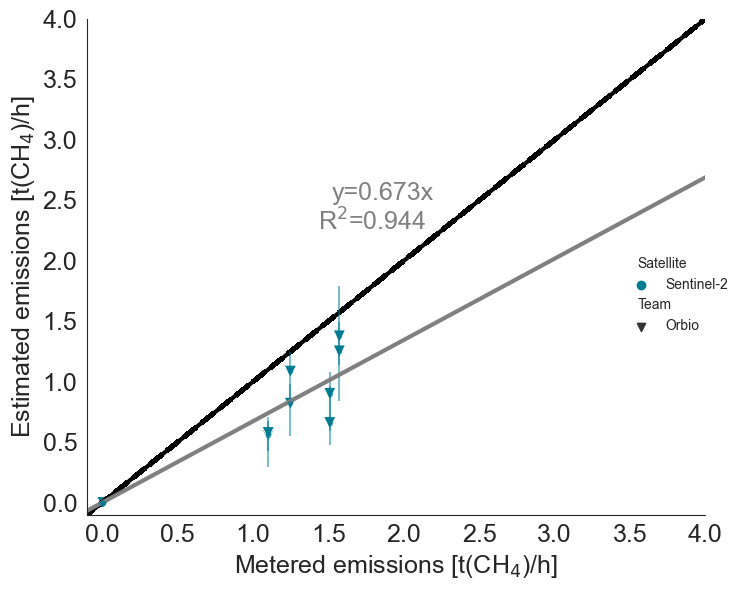

In [228]:
nonzeroRetrievalsBySatelliteTeam = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('OperatorSet').size()
nonzeroWithinCIBySatelliteTeam = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('OperatorSet').size()
nonzeroWithinCIBySatelliteTeam/nonzeroRetrievalsBySatelliteTeam
# nonzeroWithinCI
# nonzeroRetrievalsBySatellite

In [145]:
nonzeroRetrievalsBySatellite = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('Satellite').size()
nonzeroWithinCIBySatellite = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('Satellite').size()
nonzeroWithinCIBySatellite/nonzeroRetrievalsBySatellite

'#007C92'

In [ ]:
# sns.lineplot(data=xy_df, x='x', y='y')
# xy_df = pd.DataFrame(data={'x':x_domain, 'y':y_pred}, index=np.arange(len(x_domain)))
# x_domain, y_pred
# sns.lineplot(data=xy_df)
# (np.array([lims[0], lims[1]]).reshape(-1,1)).shape
# axisbound
# selectedSatelliteResultsZeros.loc[selectedSatelliteResultsZeros['Estimate (TPH) num'] > 0, ['Team', 'Estimate (TPH) num']]
zerosPlot = sns.scatterplot(data=selectedSatelliteResultsZeros, x='ch4_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, alpha=0.4, legend=False)

Generate wind roses for selected data points

In [25]:
# def plot_windrose(start_t, stop_t):
start_t = datetime.strptime('11/18/22 18:20', '%m/%d/%y %H:%M')
stop_t = datetime.strptime('11/18/22 18:25', '%m/%d/%y %H:%M')
""" Plot a wind rose for wind speed and direction values given a start and stop time.
Inputs:
  - start_t, stop_t are datetime objects

Outputs: A wind rose for the selected period
"""

if start_t.date() != stop_t.date():
    # End function if start and end t are on different dates
    print(
        'Do not attempt to calculate average flow across multiple dates. Please consider a new start or end time.')
    # return
elif start_t.date() > stop_t.date():
    print('Start time is after end time. Time for *you* to do some debugging!')
    # return
else:
    # Load data
    file_name = start_t.strftime('%m_%d')
    # use subclass Path (instead of PurePath) because we need to check if the file exists
    file_path = pathlib.Path('03_wind_data', f'{file_name}.csv')

    # Check if we have a meter file for the input date
    if not file_path.is_file():
        # If file does not exist, we did not conduct releases on that day.
        # Set all values of results_summary to zero or np.nan
        results_summary = {
            'average_windspeed': np.nan,
            'average_winddirection': np.nan,
            'stdev_windspeed': np.nan,
            'stdev_winddirection': np.nan,
        }
    else:
        # If file exists, calculate flow rate summary info:
        # Select data for averaging
        wind_data = pd.read_csv(file_path, parse_dates=['datetime'])
        time_ave_mask = (wind_data['datetime'] >= start_t) & (wind_data['datetime'] <= stop_t)
        average_period = wind_data.loc[time_ave_mask].copy()
        length_before_drop_na = len(average_period)

        # Drop rows with NA values
        average_period.dropna(axis='index', inplace=True, thresh=7)
        length_after_drop_na = len(average_period)
        dropped_rows = length_before_drop_na - length_after_drop_na
        if dropped_rows > 0:
            print(f'Number of rows that were NA in the average period ({start_t} to {stop_t}): {dropped_rows}')
    average_period
    # windrose.plot_windrose(average_period, )


NameError: name 'average_period' is not defined

In [29]:
file_path #.is_file()
# windrose.plot_windrose()

PosixPath('03_wind_data/11_18.csv')